# cell2func

> Convert desired notebook cells to functions. 

Detects function inputs automatically and function outputs semi-automatically. In the latter case, hints are provided to the developer to refine the list of outputs per each cell.

In [1]:
#| default_exp core.cell2func

In [2]:
#| export
import pdb
from typing import List, Optional, cast
from xxlimited import Str
import ipdb
from curses.ascii import isxdigit
from textwrap import indent
from pyclbr import Function
import joblib
import os
import re
import argparse
import shlex
from dataclasses import dataclass
from functools import reduce
from pathlib import Path
import sys
import ast
from ast import NodeVisitor
import logging
import warnings
import copy

from IPython import get_ipython
from IPython.core.magic import (
    Magics,
    magics_class,
    line_magic,
    cell_magic,
    line_cell_magic,
)
from IPython.core.magic_arguments import argument, magic_arguments, parse_argstring
from IPython.utils.capture import capture_output
import ipynbname
from sklearn.utils import Bunch
from fastcore.all import argnames
import nbdev

from nbmodular.core import function_io
from nbmodular.core.utils import set_log_level


In [3]:
# used for tests and examples
import pytest
import shutil
from nbmodular.core.utils import cd_root

In [4]:
cd_root()

## bunch_io

In [5]:
#| export
def bunch_io(func):
    def bunch_wrapper(*args, **kwargs):
        if (len(args) > 1) or ((len(args) == 1) and not isinstance(args[0], Bunch)):
            raise ValueError("can only accept Bunch as positional argument")
        if len(args) == 1:
            bunch = args[0]
            f_args = {
                k: kwargs[k] for k in kwargs if k in inspect.signature(f).parameters
            }
        else:
            f_args = {}
            for k in kwargs:
                if isinstance(kwargs[k], Bunch):
                    bunch = kwargs[k]
                    f_args.update(
                        {
                            k: bunch[k]
                            for k in bunch
                            if k in inspect.signature(f).parameters
                        }
                    )
                elif k in inspect.signature(f).parameters:
                    f_args[k] = kwargs[k]
        result = func(**f_args)
        bunch.update(result)
        return bunch

    return bunch_wrapper


## get_non_callable

### get_non_callable_ipython

In [6]:
#| export
import pdb


def get_non_callable_ipython(variables_to_inspect, locals_, self=None):
    """
    Store `variables` in dictionary entry `self.variables_field[function]`
    """
    frame_number = 0
    ##pdb.no_set_trace()

    while not isinstance(self, FunctionProcessor):
        try:
            fr = sys._getframe(frame_number)
        except:
            break
        args = argnames(fr, True)
        if len(args) > 0:
            self = fr.f_locals[args[0]]
        frame_number += 1

    if isinstance(self, FunctionProcessor):
        non_callable_variables = f"{variables_to_inspect}_"
        self[non_callable_variables] = []
        for name in self[variables_to_inspect]:
            try:
                x = locals_[name]
                if not callable(x):
                    self[non_callable_variables].append(name)
            except:
                self[non_callable_variables].append(name)
        self[variables_to_inspect] = self[non_callable_variables].copy()


### get_non_callable

In [7]:
#| export
def get_non_callable(variables):
    non_callable = []
    for name in variables:
        try:
            x = eval(name)
            if not callable(x):
                non_callable.append(name)
        except:
            non_callable.append(name)
    return non_callable


## get_ast

In [8]:
#| export
def get_ast(code):
    print(ast.dump(ast.parse(code), indent=2))


def remove_duplicates_from_list(list_with_potential_duplicates):
    list_without_duplicates = []
    for x in list_with_potential_duplicates:
        if x not in list_without_duplicates:
            list_without_duplicates.append(x)
    return list_without_duplicates


## VariableClassifier

In [9]:
#| export
class VariableClassifier(NodeVisitor):
    def __init__(self, *args, **kwargs):
        self.created_variables = []
        self.loaded_names = []
        self.previous_variables = []
        super().__init__(*args, **kwargs)

    def generic_visit(self, node):
        if isinstance(node, ast.Name):
            if (
                isinstance(node.ctx, ast.Store)
                and node.id not in self.created_variables
            ):
                self.created_variables.append(node.id)
            if isinstance(node.ctx, ast.Load) and node.id not in self.loaded_names:
                self.loaded_names.append(node.id)
                if node.id not in self.created_variables:
                    self.previous_variables.append(node.id)
        super().generic_visit(node)


## add_dict_values

In [10]:
#| export
def add_dict_values(d: dict):
    return reduce(lambda x, y: ("+", x[1] + y[1]), d.items())[1]


## cache output

In [11]:
#| export
def run_cell_and_cache(
    cell: str,
    load_disk: bool = False,
    save_disk: bool = False,
    output_path: Optional[Path] = None,
    load_memory: bool = False,
    save_memory: bool = False,
    memory: Optional[dict] = None,
    memory_key: Optional[str] = None,
    error_if_not_loaded: bool = False,
) -> None:
    if (load_disk or save_disk) and output_path is None:
        raise ValueError(
            "output_path cannot be None if load_disk or save_disk are True."
        )
    output_path = cast(Path, output_path)
    if (load_memory or save_memory) and (memory is None or memory_key is None):
        raise ValueError(
            "neither memory nor memory_key can be None if load_memory or save_memory are True."
        )
    obtained_output = False
    if load_memory and memory.get(memory_key) is not None:
        output = memory[memory_key]
        obtained_output = True
    elif load_disk and output_path.exists():
        output = joblib.load(output_path)
        obtained_output = True
    if not obtained_output:
        if error_if_not_loaded:
            raise RuntimeError("Previous output not found.")
        if save_memory or save_disk:
            with capture_output(True, True, True) as output:
                get_ipython().run_cell(cell)
            obtained_output = True
        else:
            output = get_ipython().run_cell(cell)
    if save_memory:
        memory[memory_key] = output
    if save_disk and not (load_disk and output_path.exists()):
        output_path.parent.mkdir(parents=True, exist_ok=True)
        joblib.dump(output, output_path)
    if obtained_output:
        output.show()
    return output


### Example usage

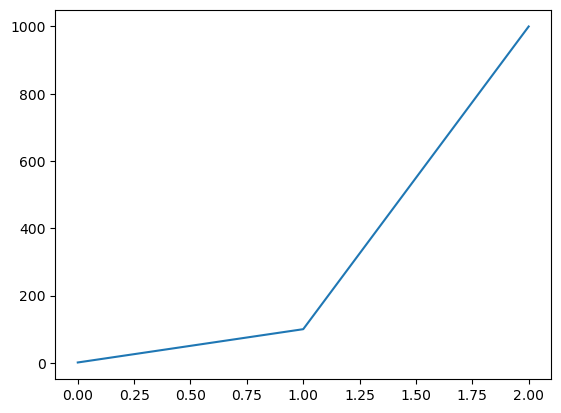

In [12]:
memory={}
cell=(
"""
import matplotlib.pyplot as plt
plt.plot ([1, 100, 1000])
"""
)
run_cell_and_cache (
    cell,
    save_memory=True,
    memory=memory,
    memory_key="previous_plot",
);

or a simple computation:

In [13]:
cell=(
"""
3+4
"""
)
output=run_cell_and_cache (
    cell,
    save_memory=True,
    memory=memory,
    memory_key="previous_sum",
)

7

The returned object is of class CapturedIO:

In [14]:
assert output.__class__.__name__ == "CapturedIO"

When printing to console or notebook, the returned object contains information about the printed text:

In [15]:
assert len(output.outputs)==1 and output.outputs[0].data["text/plain"]=="7"
assert sorted(memory) == sorted (["previous_sum", "previous_plot"])

Subsequent calls can load a previous capture from memory, without needing to run the code in the cell. We check this by passing a code that should not be run:

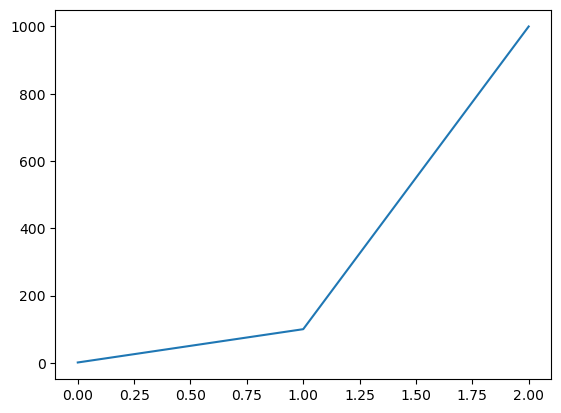

In [16]:
should_not_run_cell=(
"""
raise RuntimeError("cell should not run")
"""
)
run_cell_and_cache (
    should_not_run_cell,
    load_memory=True,
    memory=memory,
    memory_key="previous_plot",
);

In [17]:
assert memory.get("previous_plot").__class__.__name__ == "CapturedIO"

Raises error if couln't load and error_if_not_loaded is True:

In [18]:
with pytest.raises (RuntimeError):
    run_cell_and_cache (
        cell,
        load_memory=True,
        memory=memory,
        memory_key="previous_plot_bis",
        error_if_not_loaded=True,
    );

Can also save to disk:

In [19]:
memory={}
test_result_folder=Path("test_run_cell_and_cache")
output_path=test_result_folder / "previous_sum.pk"
run_cell_and_cache (
    cell,
    save_memory=True,
    save_disk=True,
    output_path=output_path,
    memory=memory,
    memory_key="previous_sum",
);

7

In [20]:
assert "previous_sum" in memory
assert output_path.exists()
shutil.rmtree (output_path.parent, ignore_errors=True)

or save only to disk but not to memory:

In [21]:
memory={}
run_cell_and_cache (
    cell,
    save_disk=True,
    output_path=output_path,
    memory=memory,
    memory_key="previous_sum",
);

7

In [22]:
assert "previous_sum" not in memory
assert output_path.exists()

It doesn't save into disk if loaded from disk...

In [23]:
# run 2+8 computation
_=run_cell_and_cache (cell="2+8", load_disk=True, save_disk=True, output_path=output_path )

# check that saved capture is still 7
output=joblib.load (output_path)
assert len(output.outputs)==1 and output.outputs[0].data["text/plain"]=="7"

7

But it does save if not loaded, even if the output existed before

In [24]:
# run 2+8 computation
_=run_cell_and_cache (cell="2+8", save_disk=True, output_path=output_path )

# check that saved capture is 10
output=joblib.load (output_path)
assert len(output.outputs)==1 and output.outputs[0].data["text/plain"]=="10"

# clean results
shutil.rmtree (output_path.parent, ignore_errors=True)

10

::: {.content-hidden}
## FunctionProcessor
:::

In [25]:
#|export
class FunctionProcessor(Bunch):
    """
    Function processor.
    """

    def __init__(
        self,
        **kwargs,
    ):
        self.is_class = False
        self.is_pipeline = False
        self.pipeline_name_or_default = None
        super().__init__(
            **kwargs,
        )

    def to_file(self, file_path, mode="w"):
        with open(file_path, mode=mode) as file:
            file.write(self.code)

    def write(self, file):
        file.write(self.code)
        file.write("\n")

    def print(self):
        print(self.code)

    def __getattr__(self, k):
        ##pdb.no_set_trace()
        try:
            v = super().__getattr__(k)
            return v
        except:
            if "current_values" in self.keys() and k in self.current_values:
                return self.current_values[k]
            else:
                return None

    def get_args_kwargs_and_defaults(self, cell):
        # TODO: move this import to the top of the file and
        # finish the implementation of this function if required
        import inspect

        get_ipython().run_cell(cell)
        function = self.run_code_and_store_its_local_values(
            return_variables=[self.name]
        )
        return inspect.signature(function)

    def _add_io(
        self,
    ):
        self._add_and_evaluate_io_kwargs()
        self._add_code_for_loading_result()
        self._add_code_for_saving_result()

    def update_code(
        self,
        arguments=None,
        kwarguments=None,
        return_values=None,
        display=False,
        run=True,
    ) -> None:
        """
        Updates the original code found in the cell.

        For this purpose, it makes use of `arguments`, `kwarguments`, `return_values`, `self.created_variables`,
        `self.previous_values` and `self.current_values`
        """
        if self.io_code:
            self._add_io()
        if self.permanent and run:
            get_ipython().run_cell(self.code)
            return
        if self.data and not self.test:
            arguments = []
            arguments = "test=False"
            kwarguments = dict(test=False)
        else:
            if arguments is not None:
                arguments += [
                    k
                    for k in self.include_input
                    if k not in arguments and k not in kwarguments and "=" not in k
                ]
                arguments = [k for k in arguments if k not in self.exclude_input]
                self.arguments = arguments
            if kwarguments is not None:
                kwarguments |= {
                    k.split("=")[0]: k.split("=")[1]
                    for k in self.include_input
                    if k not in kwarguments and k not in arguments and "=" in k
                }
                kwarguments = {
                    k: kwarguments[k]
                    for k in kwarguments
                    if k not in self.exclude_input
                }
                self.kwarguments = kwarguments
            arguments = ", ".join(self.arguments)
            if len(self.kwarguments) > 0:
                kwarguments = {
                    k: (
                        self.kwarguments[k]
                        if not isinstance(self.kwarguments[k], str)
                        else f'"{self.kwarguments[k]}"'
                    )
                    for k in self.kwarguments
                }
                if len(arguments) > 0:
                    arguments += ", "
                arguments += ", ".join([f"{k}={kwarguments[k]}" for k in kwarguments])
        unpack_input_code = ""
        pack_output_code = ""
        bunch_variable = None
        if self.unpack_bunch is not None:
            bunch_name = self.unpack_bunch
            bunch_variable = (
                self.previous_values[bunch_name]
                if bunch_name in self.previous_values
                else self.current_values[bunch_name]
            )
            if not isinstance(bunch_variable, dict):
                raise ValueError(f"{bunch_name} not found, or not instance of dict")
            unpack_input_code = "".join(
                [
                    f'{" " * self.tab_size}{k} = {bunch_name}["{k}"]\n'
                    for k in bunch_variable
                ]
            )
            if self.pack_all:
                pack_output_code = "".join(
                    [
                        f'{" " * self.tab_size}{bunch_name}["{k}"] = {k}\n'
                        for k in bunch_variable
                    ]
                )
            else:
                pack_output_code = "".join(
                    [
                        f'{" " * self.tab_size}{bunch_name}["{k}"] = {k}\n'
                        for k in bunch_variable
                        if k in self.created_variables
                    ]
                )

        if self.return_all is None:
            self.return_all = False
        if self.only_posterior is None:
            self.only_posterior = False
        if self.return_all and self.only_posterior:
            raise ValueError(
                "only one of return-all or only-posterior can be indicated"
            )
        if self.return_all or (self.unpack_bunch and not self.only_posterior):
            return_values = self.created_variables
        if return_values is not None:
            return_values += [k for k in self.include_output if k not in return_values]
            return_values = [k for k in return_values if k not in self.exclude_output]
            if bunch_variable is not None:
                new_return_values = [
                    k for k in return_values if k not in bunch_variable
                ]
                new_return_values += [
                    k.split("=")[0]
                    for k in self.include_input
                    if k not in bunch_variable
                ]
                pack_output_code += "".join(
                    [
                        f'{" " * self.tab_size}{bunch_name}["{k}"] = {k}\n'
                        for k in new_return_values
                    ]
                )
                return_values = [bunch_name]
            self.return_values = return_values
        elif self.unpack_bunch is not None:
            self.return_values = [bunch_name]

        if self.returns_dict:
            return_values = (
                "dict (\n" + "".join([f"{x}={x},\n" for x in self.return_values]) + ")"
            )
        if self.returns_bunch:
            return_values = (
                "Bunch (\n" + "".join([f"{x}={x},\n" for x in self.return_values]) + ")"
            )
        else:
            return_values = ", ".join(self.return_values)
        function_code = ""
        tab_size = self.tab_size if not self.defined else 0
        for line in self.original_code.splitlines():
            if "if True:" not in line:
                function_code += f'{" " * tab_size}{line}\n'
        if return_values != "":
            return_line = f"return {return_values}"
            return_line = f'{" " * self.tab_size}{return_line}\n'
        else:
            return_line = ""
        function_calls = "" if "function_calls" not in self else self.function_calls
        signature = f"def {self.name}({arguments}):"
        # store parts
        self.code_parts = Bunch(
            signature=f"{signature}\n",
            function_calls=function_calls,
            unpack_input_code=unpack_input_code,
            function_code=function_code,
            pack_output_code=pack_output_code,
            return_line=return_line,
        )
        if self.method:
            # we indent each part of the code separately and then join them
            # the indentation is done separately to allow nbm_update to
            # use the indedent part, in particular the return line
            # this might be handy also for other functionalities in the future
            for part, code_part in self.code_parts.items():
                indented_code = ""
                for line in code_part.splitlines():
                    indented_code += f'{" " * self.tab_size}{line}\n'
                self.code_parts[part] = indented_code

        # assemble function parts into single text
        self.code = add_dict_values(self.code_parts)
        get_ipython().run_cell(self.code)
        if display:
            print(self.code)

    def get_ast(self, original=True, code=None):
        if code is None:
            code = self.original_code if original else self.code
        get_ast(code)

    def _identify_previous_and_created_variables_with_visitor(self, root):
        self.variable_classifier.visit(root)
        self.created_variables = self.variable_classifier.created_variables
        self.loaded_names = self.variable_classifier.loaded_names
        self.previous_variables = self.variable_classifier.previous_variables

    def _identify_previous_and_created_variables(self, root):
        # ---------------------------------------
        # newly created names: candidates for return list and not for argument list
        non_unique_created_variables = [
            node.id
            for node in ast.walk(root)
            if isinstance(node, ast.Name) and isinstance(node.ctx, ast.Store)
        ]
        self.created_variables = remove_duplicates_from_list(
            non_unique_created_variables
        )

        # ---------------------------------------
        # names defined before: candidates for arguments list, if they are not callable
        non_unique_loaded_names = [
            node.id
            for node in ast.walk(root)
            if isinstance(node, ast.Name) and isinstance(node.ctx, ast.Load)
        ]
        self.loaded_names = remove_duplicates_from_list(non_unique_loaded_names)

        # A previous variable is a variable that is loaded and that existed before the
        # current function. We ensure the first condition here, and we will ensure the second
        # condition when calling match_variables_and_locals, where we only keep variables that
        # also exist in previous_values dict.
        self.previous_variables = self.loaded_names
        if (
            self.unpack_bunch is not None
            and self.unpack_bunch not in self.previous_variables
        ):
            self.previous_variables.append(self.unpack_bunch)

    def parse_variables(self, code=None):
        """
        Finds different types of variables used in the code, based on AST.

        Types of variables found:
            - `created_variables`
            - `loaded_names`
            - `previous_variables`
            - `argument_variables`
            - `read_only_variables`
            - `all_variables`
        """

        if code is None:
            code = self.original_code
        # variable parsing
        root = ast.parse(code)

        self._identify_previous_and_created_variables(root)

        # names that appear as arguments in functions -> some defined created the current function, some in the current one
        v = [node for node in ast.walk(root) if isinstance(node, ast.Call)]
        non_unique_argument_variables = [
            y.id for x in v for y in x.args if isinstance(y, ast.Name)
        ]
        self.argument_variables = remove_duplicates_from_list(
            non_unique_argument_variables
        )

        # argument variables might still be modified in the function, so they need to be marked as I/O, i.e., candidates for return list and for argument list

        # loaded names that are not arguments and not created in the current function are most probably read-only, i.e., not candidates for return list
        self.read_only_variables = [
            x for x in self.previous_variables if x not in self.argument_variables
        ]
        self.posterior_variables = []
        self.all_variables = self.created_variables.copy()
        self.all_variables += [
            k for k in self.previous_variables if k not in self.all_variables
        ]
        self.all_variables += [
            k for k in self.argument_variables if k not in self.all_variables
        ]

    def run_cell_and_cache(
        self,
        code: str,
        only_run_no_capture: bool = False,
    ) -> None:
        if only_run_no_capture:
            get_ipython().run_cell(code)
        else:
            run_cell_and_cache(
                code,
                load_disk=self.load_capture_disk,
                save_disk=self.save_capture_disk,
                load_memory=self.load_capture_memory,
                save_memory=self.save_capture_memory,
                memory=self,
                memory_key="capture",
                output_path=self.cell_processor.cell_captures_path_to_folder
                / (self.name + ".pk"),
            )

    def run_code_and_store_its_local_values(
        self,
        field="shared_variables",
        code="",
        store_values=True,
        return_variables=None,
    ):
        """Runs code and stores local variables in field `field`of self"""
        code_to_run1 = f"""
from nbmodular.core.cell2func import retrieve_nb_locals_through_memory
retrieve_nb_locals_through_memory ("{field}", locals ())
"""
        code_to_run2 = """
from nbmodular.core.cell2func import retrieve_nb_locals_through_disk
retrieve_nb_locals_through_disk (locals ())
"""
        if code != "":
            self.run_cell_and_cache(code)
        self.run_cell_and_cache(code_to_run1, only_run_no_capture=True)

        if "created_current_values" not in self[field]:
            self.logger.debug("storing local variables in disk")
            self.run_cell_and_cache(code_to_run2, only_run_no_capture=True)
            self[field] = joblib.load("variable_values.pk")
            os.remove("variable_values.pk")
        else:
            del self[field]["created_current_values"]

        if not store_values:
            self[field] = {k: "__REMOVED__" for k in self[field]}

        if return_variables is not None:
            variables = self[field]
            del self[field]
            if return_variables == "all":
                return variables
            else:
                return {variables: variables[k] for k in return_variables}

    def _create_function_info_object_with_only_parsed_variables(self):
        keys = dict(
            argument_variables=self.argument_variables,
            read_only_variables=self.read_only_variables,
            previous_variables=self.previous_variables,
            created_variables=self.created_variables,
        )
        joblib.dump(keys, "function_processor_keys.pk")
        joblib.dump(dict(self), "function_processor.pk")

        # pdb.no_set_trace()
        keys_update_code = f"""
import joblib
from nbmodular.core.cell2func import FunctionProcessor
from nbmodular.core.cell2func import get_non_callable

{self.name}_info = joblib.load ('function_processor.pk')
{self.name}_info = FunctionProcessor (**{self.name}_info)

keys = joblib.load ('function_processor_keys.pk')
{self.name}_info.update ({{k: get_non_callable(keys[k]) for k in ['argument_variables', 'read_only_variables', 'previous_variables', 'created_variables']}})
"""
        get_ipython().run_cell(keys_update_code)
        os.remove("function_processor_keys.pk")
        os.remove("function_processor.pk")

    def _create_function_info_object(self):
        info_object_code = f"""
import joblib
from nbmodular.core.cell2func import FunctionProcessor
from nbmodular.core.cell2func import acceptable_variable

variable_values = locals()
variable_values = {{k: variable_values[k] for k in variable_values if acceptable_variable(variable_values, k)}}
{self.name}_info = joblib.load ('function_processor.pk')
{self.name}_info = FunctionProcessor (**{self.name}_info)
{self.name}_info.current_values = variable_values
"""
        get_ipython().run_cell(info_object_code)

    def _update_function_info_object(self):
        keys = dict(
            current_values_keys=list(self.current_values.keys()),
            previous_values_keys=list(self.previous_values.keys()),
            argument_variables=self.argument_variables,
            read_only_variables=self.read_only_variables,
            previous_variables=self.previous_variables,
            created_variables=self.created_variables,
        )
        joblib.dump(keys, "function_processor_keys.pk")

        # pdb.no_set_trace()
        keys_update_code = f"""
import joblib
keys = joblib.load ('function_processor_keys.pk')
{self.name}_info.current_values = {{k: {self.name}_info.current_values[k] for k in keys['current_values_keys']}}
{self.name}_info.previous_values = {{k: '__REMOVED__' for k in keys['previous_values_keys']}}
{self.name}_info.update ({{k: keys[k] for k in ['argument_variables', 'read_only_variables', 'previous_variables', 'created_variables']}})
"""
        get_ipython().run_cell(keys_update_code)
        os.remove("function_processor_keys.pk")

    def run_code_and_collect_locals(
        self,
        code=None,
        is_test_function=False,
        store_values=True,
        first_call=True,
        function_in_previous_cells=None,
        run=True,
    ):
        """
        Runs the code in the function, and collects local variables.

        It populates the following dictionaries of local variables:
        `previous_values` and `current_values`

        It modifies the following classification of variables:
            - `previous_variables`
            - `argument_variables`
            - `read_only_variables`
            - `all_variables`

        """
        if code is None:
            code = self.original_code

        # In order to avoid pickling errors, we need
        # to replace the field self.cell_processor with
        # something pickable, e.g., a Bunch, and restore the original
        # field after pickling.
        cell_processor = self.cell_processor
        self.cell_processor = Bunch(
            cell_captures_path_to_folder=cell_processor.cell_captures_path_to_folder
        )
        joblib.dump(dict(self), "function_processor.pk")
        self.cell_processor = self.cell_processor

        if not is_test_function:
            # pdb.no_set_trace()
            if first_call:
                self.run_code_and_store_its_local_values(
                    "previous_values", code="", store_values=store_values
                )
                if self.copy_locals:
                    self.previous_values = copy.deepcopy(self.previous_values)
            if function_in_previous_cells is not None:
                # if previous_values is in current_values of previous cells of this function, it cannot be a previous value
                self.previous_values = {
                    k: self.previous_values[k]
                    for k in self.previous_values
                    if k not in function_in_previous_cells.current_values
                }
            if run:
                self.run_code_and_store_its_local_values(
                    "current_values", code=code + "\n", store_values=store_values
                )
            else:
                self.current_values = {k: None for k in self.created_variables}
        else:
            get_ipython().run_cell(
                'from nbmodular.core.cell2func import get_non_callable_ipython\nget_non_callable_ipython ("previous_variables", locals())'
            )
            get_ipython().run_cell(
                'from nbmodular.core.cell2func import get_non_callable_ipython\nget_non_callable_ipython ("created_variables", locals())'
            )
            self.previous_values = {k: None for k in self.previous_variables}
            self.current_values = {k: None for k in self.created_variables}

        self._create_function_info_object()
        self.match_variables_and_locals(
            function_in_previous_cells=function_in_previous_cells
        )
        os.remove("function_processor.pk")

    def match_variables_and_locals(self, function_in_previous_cells=None):
        """
        Refines classification of variables in code based on local variables found before and after running.

        Refined types:
            - `previous_variables`
            - `argument_variables`
            - `read_only_variables`
            - `all_variables`

        It also refines the following dictionaries of local variables: `previous_values` and `current_values`
        """

        # pdb.no_set_trace()
        # previous variables / values
        previous_values = (
            self.previous_values
            if function_in_previous_cells is None
            else self.previous_values | function_in_previous_cells.previous_values
        )
        previous_variables = (
            self.previous_variables
            if function_in_previous_cells is None
            else self.previous_variables + function_in_previous_cells.previous_variables
        )
        self.previous_variables = [
            k for k in self.previous_variables if k in previous_values
        ]
        self.previous_variables += [
            k
            for k in self.argument_variables
            if k in previous_values and k not in self.previous_variables
        ]
        self.previous_variables += [
            k
            for k in self.created_variables
            if k in previous_values
            and k in self.loaded_names + self.argument_variables
            and k not in self.previous_variables
        ]
        self.previous_values = {
            k: self.previous_values[k]
            for k in self.previous_values
            if k in previous_variables
        }

        # created variables / current values
        self.current_values = {
            k: self.current_values[k]
            for k in self.current_values
            if k in self.created_variables or k in self.return_values
        }
        self.all_values = {**self.previous_values, **self.current_values}
        self.argument_variables = [
            k for k in self.argument_variables if k in self.all_values
        ]
        self.read_only_variables = [
            k for k in self.read_only_variables if k in self.all_values
        ]

        self.all_variables = self.created_variables.copy()
        self.all_variables += [
            k for k in self.previous_variables if k not in self.all_variables
        ]
        self.all_variables += [
            k for k in self.argument_variables if k not in self.all_variables
        ]

        self.current_values = {
            k: self.current_values[k]
            for k in self.current_values
            if k in self.all_variables
        }
        self.previous_values = {
            k: self.previous_values[k]
            for k in self.previous_values
            if k in self.all_variables
        }
        self.logger.debug(
            f"Stored the following local variables in the {self.name} current_values dictionary: {list(self.current_values.keys())}"
        )

    def add_function_call(self, function):
        if "added_functions" not in self:
            self.added_functions = []
        if "function_calls" not in self:
            self.function_calls = ""
        if function.name not in self.added_functions:
            self.added_functions.append(function.name)
            self.function_calls += (
                f'{" "*self.tab_size}'
                + ",".join(function.return_values)
                + f" = {function.name}()\n"
            )

    def add_to_signature(self, input=None, output=None, **kwargs):
        if input is not None:
            self.previous_variables += input
            self.arguments += [
                k
                for k in input
                if k not in self.arguments
                and k not in self.kwarguments
                and "=" not in k
            ]
            self.kwarguments |= {
                k.split("=")[0]: k.split("=")[1]
                for k in input
                if k not in self.kwarguments and k not in self.arguments and "=" in k
            }
        if output is not None:
            self.return_values += output
            self.posterior_variables += output
        if input is not None or output is not None:
            self.signature = None
            self.update_code()

    def __str__(self):
        name = None if not hasattr(self, "name") else self.name
        created_variables = (
            self.created_variables if hasattr(self, "created_variables") else None
        )
        return f"Function {name}:\n    Arguments: {self.arguments}\n    Keyword arguments: {self.kwarguments}\n    Output: {self.return_values}\n    Created variables: {self.created_variables}"

    def __repr__(self):
        return str(self)

    def store_variables(
        self,
        path_variables,
        io_type,
        io_locals,
        load_args,
    ):
        store_variables_code = f'\nfrom nbmodular.core.cell2func import store_variables\nstore_variables ("{path_variables}", locals (), "{io_type}", {io_locals}, {load_args}, {self.return_values})'
        get_ipython().run_cell(store_variables_code)

    def get_cell_function_code(self, unique=True, first=False, last=False):
        code = self.code
        if unique:
            function_code = function.code
        elif first:
            function_code = (
                f"{self.code_parts.signature}\n"
                + self.code_parts.function_calls
                + self.code_parts.unpack_input_code
                + self.code_parts.function_code
            )
        elif last:
            function_code = (
                self.code_parts.function_code
                + self.code_parts.pack_output_code
                + self.code_parts.return_line
            )
        else:
            function_code = self.code_parts.function_code
        return function_code

    def _add_and_evaluate_io_kwargs(self):
        file_suffix = "_locals" if self.io_locals else "_result"
        self.kwarguments.update(
            load=False,
            save=False,
            io_type=self.io_type,
            io_root_path=self.io_root_path,
            io_file=(
                f"{self.name}{file_suffix}" if self.io_file is None else self.io_file
            ),
            load_args={k: str(self.load_args[k]) for k in self.load_args},
            save_args={k: str(self.save_args[k]) for k in self.save_args},
        )

        io_argument_initialization_code = f"""
exec ("load={self.load_arg}")
exec ("save={self.save_arg}")
exec ("io_type='{self.io_type}'")
exec ("io_root_path='{self.io_root_path}'")
exec ("io_folder='{self.io_folder}'")
exec ("io_file='{self.io_file}'")
exec ("load_args={self.load_args}")
exec ("save_args={self.save_args}")
"""
        get_ipython().run_cell(io_argument_initialization_code)

    def _add_code_for_saving_result(self):

        return_values = (
            f"[{self.return_values}]"
            if len(self.return_values) > 1
            else f"{self.return_values[0]}" if len(self.return_values) == 1 else "None"
        )
        new_code = (
            f"""
if save:
    function_io.save ({return_values}, path_variables, io_type, **save_args)
"""
        ).splitlines()
        new_code = new_code[1:]  # first line is empty
        # add indentation
        for i, line in enumerate(new_code):
            new_code[i] = f'{" "*self.tab_size}{line}'
        self.original_code = (
            self.original_code + "\nif True:\n" + "\n".join(new_code) + "\n\n"
        )

    def _add_code_for_loading_result(self):
        path_variables_line = (
            'path_variables = Path (io_root_path) / f"{io_file}.{io_type}"'
        )
        new_code = (
            f"""
{path_variables_line}
if load and path_variables.exists():
    result = function_io.load (path_variables, io_type, **load_args)
    return result
"""
        ).splitlines()
        new_code = new_code[1:]  # first line is empty
        # add indentation
        for i, line in enumerate(new_code):
            new_code[i] = f'{" "*self.tab_size}{line}'
        self.original_code = (
            "if True:\n" + "\n".join(new_code) + "\n\n" + self.original_code
        )

    def copy_values_and_run_code_in_nb(self, field="shared_variables", code=""):
        """Makes desired variables available in notebook context.

        Uses field `field` of CellProcessor object for communicating these variables.
        """

        code_with_tabs = []
        for line in code.splitlines():
            code_with_tabs += [f'{" "*self.tab_size}{line}']
        code_with_tabs = "\n".join(code_with_tabs)

        code_to_run1 = f"""
from nbmodular.core.cell2func import retrieve_function_values_through_memory

variables_to_insert = retrieve_function_values_through_memory ("{field}")
if "retrieve_function_values_through_memory" in variables_to_insert:
{code_with_tabs}
    del variables_to_insert
"""

        code_to_run2 = f"""
from nbmodular.core.cell2func import retrieve_function_values_through_disk

variables_to_insert = retrieve_function_values_through_disk ()
{code}
os.remove ('variable_values.pk')
"""

        get_ipython().run_cell(code_to_run1)
        if "retrieve_function_values_through_memory" not in self:
            get_ipython().run_cell(code_to_run2)

    def copy_values_in_nb(self, field="shared_variables"):
        copy_values_in_nb(self, field=field)

    def restore_locals(self):
        delete_current_values_code = f"""
for k in variables_to_insert:
    exec ("del k")
"""
        self.copy_values_and_run_code_in_nb(
            field="current_values", code=delete_current_values_code
        )

        restore_previous_values_code = f"""
for k, v in variables_to_insert.items():
    exec ("k=str(v)")
"""
        self.copy_values_and_run_code_in_nb(
            field="previous_values", code=restore_previous_values_code
        )


In [26]:
# Trick used for forcing FunctionProcessor class be the same as the one imported from cell2func
CurrentFunctionProcessor=FunctionProcessor
import nbmodular.core.cell2func as cf
cf.FunctionProcessor = CurrentFunctionProcessor

### Example

In [27]:
cell_captures_path_to_folder=Path('.cell_captures/core/cell2func')
fp=FunctionProcessor (
    name="myf", 
    cell_processor=Bunch(cell_captures_path_to_folder=cell_captures_path_to_folder),
    save_capture_disk=True,
)
fp.run_cell_and_cache ("1+3")
cell_captures_path_to_file = cell_captures_path_to_folder / f"{fp.name}.pk"
assert cell_captures_path_to_file.exists()
output = joblib.load (cell_captures_path_to_file)
assert len(output.outputs)==1 and output.outputs[0].data["text/plain"]=="4"
# clean
shutil.rmtree (cell_captures_path_to_folder, ignore_errors=True)

4

In [28]:
# Set attributes in fp object that are used by the method
# `run_code_and_store_its_local_values`:
logger=logging.getLogger("testing_function_processor_logger")
fp.update(previous_values={}, current_values={}, logger=logger)

# Call the method without and with code:
fp.run_code_and_store_its_local_values("previous_values", code="", store_values=True)
fp.run_code_and_store_its_local_values("current_values", code="1+3\n", store_values=True)

# Check results:
assert cell_captures_path_to_file.exists()
output = joblib.load (cell_captures_path_to_file)
assert len(output.outputs)==1 and output.outputs[0].data["text/plain"]=="4"
# clean
shutil.rmtree (cell_captures_path_to_folder, ignore_errors=True)

4

::: {.content-hidden}
## CellProcessor
:::

### update_cell_code

In [29]:
#| export
def update_cell_code(cell, defined=False):
    original_code = ""
    for line in cell.splitlines():
        if "return" not in line and "#|" not in line:
            original_code += line + "\n"

    if defined:
        v = original_code.split(":")
        v[1] = v[1][1:]
        if len(v) > 0 and v[1][0] in ["\n", "\r"]:
            v[1] = v[1][1:]
        original_code = ":".join(v[1:])

    # Hack for avoiding indentation in defined functions.
    # If True is removed later when calling FunctionProcessor's update_code
    cell = "if True:\n" + original_code if defined else original_code

    return cell


### add_function_to_list

In [30]:
#|export
def add_function_to_list(function, function_list, idx=None, position=None):
    if idx is None:
        function_list.append(function)
        idx = -1
    else:
        function_list[idx] = function
    if position is not None:
        function.idx = position
        function_list.insert(position, function)
        if idx == -1:
            remove_idx = -1
        elif position < idx:
            remove_idx = idx + 1
        else:
            remove_idx = idx
        assert function_list[remove_idx].name == function.name
        del function_list[remove_idx]
        for idx, function in enumerate(function_list):
            function.idx = idx
    return function_list


### get_args_and_defaults_from_function_in_cell

#### get_args_and_defaults

In [31]:
#| export
def get_args_and_defaults(list_args, list_defaults):
    if len(list_defaults) == 0:
        args_without_defaults = [arg.arg for arg in list_args]
        args_with_defaults = []
        default_values = []
        return args_without_defaults, args_with_defaults, default_values

    default_nodes = [
        x
        for x in list_defaults
        if isinstance(x, ast.Constant)
        or isinstance(x, ast.Attribute)
        or isinstance(x, ast.Name)
    ]
    if len(default_nodes) == 0 and len(list_defaults) > 0:
        raise ValueError("Default values are neither constant, name, or attribute")
    default_values = []
    for x in default_nodes:
        if isinstance(x, ast.Constant):
            default_values.append(x.value)
        elif isinstance(x, ast.Name):
            default_values.append(x.id)
        elif isinstance(x, ast.Attribute):
            y = x
            value = ""
            while isinstance(y, ast.Attribute):
                value = f"{y.attr}.{value}" if value != "" else y.attr
                y = y.value
            if isinstance(y, ast.Name):
                value = f"{y.id}.{value}"
            else:
                raise ValueError(f"Unexpected type for node {y}")
            default_values.append(value)
        else:
            raise ValueError(f"Unexpected type for node {x}")

    args_without_defaults = [arg.arg for arg in list_args[: -len(list_defaults)]]
    args_with_defaults = [arg.arg for arg in list_args[-len(list_defaults) :]]

    return args_without_defaults, args_with_defaults, default_values


#### get_args_and_defaults_from_function_in_cell

In [32]:
#| export
def get_args_and_defaults_from_ast(root):
    args_without_defaults, args_with_defaults1, default_values1 = get_args_and_defaults(
        root.body[0].args.posonlyargs + root.body[0].args.args,
        root.body[0].args.defaults,
    )
    _, args_with_defaults2, default_values2 = get_args_and_defaults(
        root.body[0].args.kwonlyargs, root.body[0].args.kw_defaults
    )

    return (
        args_without_defaults,
        args_with_defaults1 + args_with_defaults2,
        default_values1 + default_values2,
    )


def get_args_and_defaults_from_function_in_cell():
    cell = joblib.load("cell.pk")
    os.remove("cell.pk")
    root = ast.parse(cell)
    return get_args_and_defaults_from_ast(root)


### derive_paths

In [33]:
#| export
def derive_paths(
    original_path: Path,
    folder: str,
    lib_folder: str,
    file_name: str,
    cell_processor: "CellProcessor",
    code_cells_path: Path = Path(".nbmodular"),
):
    file_name_without_extension = Path(file_name).stem
    try:
        index = original_path.parts.index(folder)
        before_nbs_folder = original_path.parts[:index]
        after_nbs_folder = original_path.parts[index + 1 :]
    except:
        index = -1
    if index > -1:
        before_nbs_folder = cast(tuple, before_nbs_folder)
        after_nbs_folder = cast(tuple, after_nbs_folder)

        parts = before_nbs_folder + (lib_folder,) + after_nbs_folder
        cell_processor.file_path = Path().joinpath(*parts).parent / file_name

        parts = before_nbs_folder + ("tests",) + after_nbs_folder
        cell_processor.test_file_path = (
            Path().joinpath(*parts).parent / f"test_{file_name}"
        )

        parts = before_nbs_folder + (".cell_captures",) + after_nbs_folder
        cell_processor.cell_captures_path_to_folder = (
            Path().joinpath(*parts).parent / file_name_without_extension
        )

        parts = before_nbs_folder + (str(code_cells_path),) + after_nbs_folder
        cell_processor.path_to_code_cells_file = (
            Path().joinpath(*parts).parent / f"{file_name_without_extension}.pk"
        )
        cell_processor.code_cells_path = cell_processor.path_to_code_cells_file.parent

    else:
        cell_processor.file_path = original_path.parent / file_name
        cell_processor.test_file_path = original_path.parent / f"test_{file_name}"
        cell_processor.cell_captures_path_to_folder = (
            original_path.parent / original_path.stem
        )
        cell_processor.path_to_code_cells_file = (
            code_cells_path / f"{file_name_without_extension}.pk"
        )

    cell_processor.file_path.parent.mkdir(parents=True, exist_ok=True)
    cell_processor.test_file_path.parent.mkdir(parents=True, exist_ok=True)
    (cell_processor.cell_captures_path_to_folder / "").mkdir(
        parents=True, exist_ok=True
    )
    cell_processor.path_to_code_cells_file.parent.mkdir(parents=True, exist_ok=True)


#### Example

In [34]:
cell_processor=Bunch()
derive_paths (
    original_path=Path("root/folder_with_nb/subfolder/myfile.ipynb"),
    folder="folder_with_nb",
    lib_folder="mylib",
    file_name="hello.py",
    cell_processor=cell_processor,
    code_cells_path=Path(".nbmodular"),
)
assert cell_processor=={'file_path': Path('root/mylib/subfolder/hello.py'),
 'test_file_path': Path('root/tests/subfolder/test_hello.py'),
 'cell_captures_path_to_folder': Path('root/.cell_captures/subfolder/hello'),
 'path_to_code_cells_file': Path('root/.nbmodular/subfolder/hello.pk'),
 'code_cells_path': Path('root/.nbmodular/subfolder')}

### CellProcessor

In [35]:
# | export
class CellProcessor:
    """
    Processes the cell's code according to the magic command.
    """

    magic_commands_list = ["function", "include", "method", "class"]

    def __init__(
        self,
        tab_size=4,
        log_level="INFO",
        restrict_inputs=False,
        code_cells_path=".nbmodular",
        export_always=True,
        **kwargs,
    ):
        self.logger = logging.getLogger("CellProcessor")
        self.set_log_level(log_level)
        self.code_cells_path = Path(code_cells_path)
        self.code_cells_path.mkdir(parents=True, exist_ok=True)

        self.restrict_inputs = restrict_inputs
        self.current_function = Bunch()

        # function_info dicts and function lists for each type of function
        self.test_data_function_info = Bunch()
        self.test_data_function_list = []

        self.test_function_info = Bunch()
        self.test_function_list = []

        self.data_function_info = Bunch()
        self.data_function_list = []

        self.function_list = []
        self.function_info = Bunch()

        self.test_data_all_variables = set()
        self.test_all_variables = set()
        self.data_all_variables = set()
        self.all_variables = set()

        self.test_data_return_values = set()
        self.data_return_values = set()

        self.pipeline = None
        self.test_pipeline = None

        self.pipelines = ["default_pipeline"]

        self.test_code_cells = Bunch()
        self.code_cells = Bunch()

        self.imports = ""
        # self.test_imports = 'from sklearn.utils import Bunch\nfrom pathlib import Path\nimport joblib\nimport pandas as pd\nimport numpy as np\n'
        self.test_imports = ""

        self.tab_size = tab_size
        found_notebook = True
        try:
            self.nb_path = ipynbname.path()
        except FileNotFoundError:
            if "__vsc_ipynb_file__" in globals():
                self.nb_path = Path(globals()["__vsc_ipynb_file__"])
            else:
                self.nb_path = Path.cwd() / "temporary.ipynb"

                found_notebook = False
                warning_message = (
                    "Name of notebook could not be automatically detected. "
                    "We will be using `temporary.py` as the name of the python module "
                    "where the code from the current notebook will be exported to. "
                    "In order to change this name, run the magic command "
                    '%set file_name "<name_of_python_module>.py".'
                )
                warnings.warn(warning_message)
                # self.logger.warning (warning_message)

        self.file_name_without_extension = self.nb_path.stem
        self.file_name = self.file_name_without_extension + ".py"

        # Make the notebook always start with alphabetic character,
        # for those cases when it starts with number, e.g.
        # 10_my_notebook.ipynb => n10_my_notebook.py
        try:
            _ = int(self.file_name[0])
            self.file_name = f"n{self.file_name}"
        except ValueError:
            pass

        try:
            self.nbs_folder = self.get_nbm_path()
            self.lib_folder = self.get_lib_path()
        except:
            self.nbs_folder = "nbs"
            self.lib_folder = "my_lib"

        derive_paths(
            self.nb_path, self.nbs_folder, self.lib_folder, self.file_name, self
        )

        self.file_path.parent.mkdir(parents=True, exist_ok=True)
        self.test_file_path.parent.mkdir(parents=True, exist_ok=True)
        (self.cell_captures_path_to_folder / "").mkdir(parents=True, exist_ok=True)  # type: ignore

        self.call_history = []

        self.default_load = False
        self.default_test_load = True

        self.default_save = False
        self.default_test_save = True

        self.default_io_type = "pickle"
        self.default_test_io_type = "pickle"

        self.default_io_code = False
        self.default_test_io_code = False

        self.default_io_locals = False
        self.default_test_io_locals = True

        self.default_io_folder = self.file_name_without_extension
        self.default_test_io_folder = self.file_name_without_extension

        self.default_io_locals_root_path = "locals"
        self.default_test_io_locals_root_path = "locals"

        self.default_io_result_root_path = "results"
        self.default_test_io_result_root_path = "results"

        self.default_load_args = {}
        self.default_test_load_args = {}
        self.default_save_args = {}
        self.default_test_save_args = {}

        self.default_load_arg = False
        self.default_test_load_arg = True
        self.default_save_arg = False
        self.default_test_save_arg = True

        self.default_run = True
        self.default_test_run = True

        self.default_pipe = True
        self.default_test_pipe = False

        self.default_load_capture_disk = False
        self.default_save_capture_disk = False
        self.default_load_capture_memory = False
        self.default_save_capture_memory = False
        self.default_test_load_capture_disk = False
        self.default_test_save_capture_disk = False
        self.default_test_load_capture_memory = False
        self.default_test_save_capture_memory = False

        self.default_write = False
        self.default_test_write = False

        self.default_pipe_name = f"{self.file_name_without_extension}_pipeline"

        self._added_io_imports = False
        self.variable_classifier = VariableClassifier()

        self.export_always = export_always

        self.parser = argparse.ArgumentParser(
            description="Arguments to `function` magic cell."
        )
        self.parser.add_argument(
            "-i",
            "--input",
            type=str,
            nargs="+",
            help="Strict input. No other input considered, regardless of any dependencies.",
        )
        self.parser.add_argument(
            "--include-input",
            type=str,
            default=[],
            nargs="+",
            help="Input to be included in addition of identified dependencies on previous functions.",
        )
        self.parser.add_argument(
            "--exclude-input",
            type=str,
            default=[],
            nargs="+",
            help="Input to be excluded.",
        )
        self.parser.add_argument(
            "-o",
            "--output",
            type=str,
            nargs="+",
            help="Strict output. No other output considered, regardless of any dependencies.",
        )
        self.parser.add_argument(
            "--include-output",
            type=str,
            default=[],
            nargs="+",
            help="Output to be included in addition of identified dependencies from posterior functions",
        )
        self.parser.add_argument(
            "--exclude-output",
            type=str,
            default=[],
            nargs="+",
            help="Output to be excluded.",
        )
        self.parser.add_argument(
            "-m",
            "--merge",
            action="store_true",
            default=None,
            help="merge with previous function",
        )
        self.parser.add_argument(
            "-s", "--show", action="store_true", default=None, help="show function code"
        )
        self.parser.add_argument(
            "-l", "--load", action="store_true", default=None, help="load variables"
        )
        self.parser.add_argument(
            "--save", action="store_true", default=None, help="save variables"
        )
        self.parser.add_argument(
            "--io-code",
            action="store_true",
            default=None,
            help="add I/O code to function",
        )
        self.parser.add_argument(
            "--save-arg",
            action="store_true",
            default=None,
            help="have save=True as default arg value in function",
        )
        self.parser.add_argument(
            "--load-arg",
            action="store_true",
            default=None,
            help="have load=True as default arg value in function",
        )
        self.parser.add_argument(
            "--io-type",
            type=str,
            default="pickle",
            help="I/O functions to use. `x` means use `save_x` for saving and `load_x` for loading.",
        )
        self.parser.add_argument(
            "--io-locals",
            action="store_true",
            default=None,
            help="save/load local variables of function",
        )
        self.parser.add_argument(
            "--io-root-path",
            type=str,
            default=None,
            help="root of path where function data is stored.",
        )
        self.parser.add_argument(
            "--io-folder",
            type=str,
            default=None,
            help="Folder where the data is stored. It can be several folders `folder1/folder2/...`. "
            "If not indicated, the folder has the same name as the python module ",
        )
        self.parser.add_argument(
            "--io-file",
            type=str,
            default=None,
            help='Name of file where results are saved. If not indicated, the name of the function is used, adding "result" at the end.',
        )
        self.parser.add_argument(
            "--save-args",
            type=str,
            default="",
            help='Arguments passed to save function, like so: "param1=value1, param2=value2"',
        )
        self.parser.add_argument(
            "--load-args",
            type=str,
            default="",
            help='Arguments passed to load function, like so: "param1=value1, param2=value2"',
        )
        self.parser.add_argument(
            "--run",
            action="store_true",
            default=None,
            help="execute the contents of the cell",
        )
        self.parser.add_argument(
            "--copy-locals",
            action="store_true",
            default=None,
            help="Make a deep copy of dictionary of local variables, to be able to restore their values after running cell.",
        )
        self.parser.add_argument(
            "--returns-dict",
            action="store_true",
            default=None,
            help="function results are gathered in dictionary",
        )
        self.parser.add_argument(
            "--returns-bunch",
            action="store_true",
            default=None,
            help="function results are gathered in Bunch",
        )
        self.parser.add_argument(
            "--unpack-bunch",
            type=str,
            default=None,
            help="uses bunch variable as I/O, and unpacks its contents at beginning of function",
        )
        self.parser.add_argument(
            "--pack-all",
            action="store_true",
            default=None,
            help="pack all variables in bunch, including those not recognized as variables created or modified in function",
        )
        self.parser.add_argument(
            "--only-posterior",
            action="store_true",
            default=None,
            help="return only created / modified variables that are used in posterior functions",
        )
        self.parser.add_argument(
            "--return-all",
            action="store_true",
            default=None,
            help="return all created / modified variables even if they are not used in posterior functions",
        )
        self.parser.add_argument(
            "-t",
            "--test",
            action="store_true",
            default=None,
            help="test function / imports",
        )
        self.parser.add_argument(
            "-d", "--data", action="store_true", default=None, help="data function"
        )
        self.parser.add_argument(
            "-p",
            "--permanent",
            action="store_true",
            default=None,
            help="do not change the contents of the function",
        )
        self.parser.add_argument(
            "--fixed-io",
            action="store_true",
            default=None,
            help="do not change the inputs and outputs when %%function is applied on a defined function, e.g., %%function\ndef my_function...",
        )
        self.parser.add_argument(
            "--idx", type=int, help="position of function to debug"
        )
        self.parser.add_argument(
            "--position", type=int, help="position of function to be added"
        )
        self.parser.add_argument(
            "--history",
            action="store_true",
            default=None,
            help="resets everything, including history",
        )
        self.parser.add_argument(
            "--previous-values",
            action="store_true",
            default=None,
            help="deletes both current and previous values for each function",
        )
        self.parser.add_argument(
            "--method",
            action="store_true",
            default=None,
            help="Convert to class method.",
        )
        self.parser.add_argument(
            "--pipe-name",
            type=str,
            default="default_pipeline",
            help="name of pipeline - if default, default_pipe_name is used. This is, initially, the name of the python module.",
        )
        self.parser.add_argument(
            "--pipe",
            action="store_true",
            default=None,
            help="Insert function into pipeline.",
        )
        self.parser.add_argument(
            "--load-capture-disk",
            action="store_true",
            default=None,
            help="Load the cell ouput's capture, which has been previously stored in disk.",
        )
        self.parser.add_argument(
            "--save-capture-disk",
            action="store_true",
            default=None,
            help="Save the cell ouput's capture to disk.",
        )
        self.parser.add_argument(
            "--load-capture-memory",
            action="store_true",
            default=None,
            help="Load the cell ouput's capture, which has been previously stored in memory.",
        )
        self.parser.add_argument(
            "--save-capture-memory",
            action="store_true",
            default=None,
            help="Save the cell ouput's capture in memory.",
        )
        self.parser.add_argument(
            "--write",
            action="store_true",
            default=None,
            help="Write the function to python module, as a result of running cell.",
        )
        # Take list of actions explicitly added above with add_argument.
        # From this list, include only those where we also added an attribute
        # `default_<parameter_name>`
        self.list_of_parser_actions = [
            x.dest
            for x in self.parser._optionals._actions
            if x.__class__.__name__ == "_StoreTrueAction"
            and hasattr(self, f"default_{x.dest}")
        ]
        for action_dest in self.list_of_parser_actions:
            self.parser.add_argument(
                f"--not-{action_dest}",
                action="store_false",
                default=None,
                dest=action_dest,
                help=f"Performs opposite action to the one done by --{action_dest}. See help for that action.",
            )

    def set_load_tests(self, value):
        if value != self.default_test_load:
            self.logger.info(f"changing global load flag to {value}")
        self.default_test_load = value

    def set_save_tests(self, value):
        if value != self.default_test_save:
            self.logger.info(f"changing global save flag to {value}")
        self.default_test_save = value

    def set_run_tests(self, value):
        if value != self.default_test_run:
            self.logger.info(f"changing global run flag to {value}")
        self.default_test_run = value

    def set_file_path(self, file_path):
        self.file_path = Path(file_path)
        derive_paths(
            self.file_path, self.lib_folder, self.lib_folder, self.file_path.name, self
        )
        self.set_file_name(self.file_path.name)

    def get_pipeline_name(self, pipeline_name_or_default="default_pipeline"):
        return (
            self.default_pipe_name
            if pipeline_name_or_default is None
            or pipeline_name_or_default == "default_pipeline"
            else pipeline_name_or_default
        )

    def set_file_name(self, file_name):
        if self.file_name == file_name:
            return
        change_default_pipe_name = (
            self.default_pipe_name == f"{self.file_name_without_extension}_pipeline"
        )
        previous_default_pipe_name = self.default_pipe_name
        self.file_name = file_name
        self.file_path = self.file_path.parent / self.file_name
        self.file_name_without_extension = self.file_path.stem
        self.test_file_path = self.test_file_path.parent / f"test_{self.file_name}"
        self.path_to_code_cells_file = (
            self.code_cells_path / f"{self.file_name_without_extension}.pk"
        )

        self.default_io_folder = self.file_name_without_extension
        if change_default_pipe_name:
            self.default_pipe_name = f"{self.file_name_without_extension}_pipeline"
            if self.default_pipe_name != previous_default_pipe_name:
                get_ipython().run_cell(
                    f"""
try:
    exec ('{self.default_pipe_name}={previous_default_pipe_name}')
    exec ('del {previous_default_pipe_name}')
except NameError:
    pass
"""
                )

    def set_log_level(self, log_level):
        set_log_level(self.logger, log_level)

    def set_pipe(self, function_name, pipeline_name):
        self.function_info[function_name].pipeline_name = pipeline_name
        if (
            pipeline_name is not None
            and pipeline_name != "None"
            and pipeline_name not in self.pipelines
        ):
            self.pipelines.append(pipeline_name)

    def set_value(self, attr, value, convert=True):
        if convert:
            try:
                value = eval(value)
            except:
                pass
        if callable(getattr(self, f"set_{attr}", None)):
            getattr(self, f"set_{attr}", None)(value)
        elif hasattr(self, attr):
            setattr(self, attr, value)
        else:
            list_of_attributes = [
                k
                for k in self.__dict__
                if not k.startswith("_")
                and not k.endswith("_")
                and not callable(getattr(self, k, None))
            ]
            raise ValueError(
                f"Cell processor has no attribute {attr}. Existing attributes are:\n{list_of_attributes}"
            )

    def debug_function(
        self, call_history=None, idx=None, name=None, test=False, data=False, **kwargs
    ):
        if call_history is not None:
            self.call_history = call_history

        if name is not None:
            function_info = self.get_function_info(test, data)

            if name not in function_info:
                idx = 0
                for func, code in self.call_history:
                    if func == name:
                        break
                    idx += 1
            else:
                idx = function_info[name].idx
        elif idx is None:
            idx = -1

        self.reset()

        for call in self.call_history[:idx]:
            self.process_function_call(*call, add_call=False)

        import ipdb

        ipdb.runcall(
            self.process_function_call, *self.call_history[idx], add_call=False
        )

    def run_call_history(self, call_history):
        for call in call_history:
            self.process_function_call(*call, add_call=False)

    def reset_function_list(
        self, function_list, previous_values=False, only_previous_values=False
    ):
        if len(function_list) == 0:
            return [], Bunch()
        if not only_previous_values:
            values_to_remove = [
                x for function in function_list for x in function.current_values.keys()
            ]
        if previous_values or only_previous_values:
            if only_previous_values:
                values_to_remove = [
                    x
                    for function in function_list
                    for x in function.previous_values.keys()
                ]
            else:
                values_to_remove += [
                    x
                    for function in function_list
                    for x in function.previous_values.keys()
                ]
        remove_variables_code = "\n".join(
            [
                f"""
            try:
                exec("del {x}")
            except:
                pass
                #print (f'could not remove {x}')
                """
                for x in values_to_remove
            ]
        )
        get_ipython().run_cell(remove_variables_code)
        return [], Bunch()

    def delete_globals(self, **kwargs):
        for test in [False, True]:
            for data in [False, True]:
                self.reset_function_list(
                    self.get_function_list(test=test, data=data),
                    previous_values=True,
                    only_previous_values=True,
                )

    def reset(self, history=False, previous_values=False, **kwargs):
        if previous_values:
            self.logger.info("Deleting previous values")

        self.test_data_function_list, self.test_data_function_info = (
            self.reset_function_list(
                self.test_data_function_list,
                self.test_data_function_info,
                previous_values=previous_values,
            )
        )
        self.test_function_list, self.test_function_info = self.reset_function_list(
            self.test_function_list,
            self.test_function_info,
            previous_values=previous_values,
        )
        self.data_function_list, self.data_function_info = self.reset_function_list(
            self.data_function_list,
            self.data_function_info,
            previous_values=previous_values,
        )
        self.function_list, self.function_info = self.reset_function_list(
            self.function_list, self.function_info, previous_values=previous_values
        )

        self.test_data_all_variables = set()
        self.test_all_variables = set()
        self.data_all_variables = set()
        self.all_variables = set()

        self.imports = ""
        self.test_imports = ""
        if history:
            self.logger.info("Removing call history")
            self.call_history = []

    def get_functions_from_pipeline(self, pipeline_name_or_default):
        function_list = self.get_function_list(
            test=False, data=True
        ) + self.get_function_list(test=False, data=False)
        return [
            f
            for f in function_list
            if f.pipeline_name_or_default == pipeline_name_or_default
        ]

    def get_pipeline_functions(self, test=False):
        if test:
            return (
                [self.test_function_info["default_test_pipeline"]]
                if "default_test_pipeline" in self.test_function_info
                else []
            )
        else:
            return [
                self.function_info[pipeline_name_of_default]
                for pipeline_name_of_default in self.pipelines
                if pipeline_name_of_default in self.function_info
            ]

    def get_function_list(
        self, test=False, data=False, all=False, include_pipelines=False
    ):
        function_list = (
            self.test_data_function_list
            if test and data
            else (
                self.test_function_list
                if test
                else self.data_function_list if data else self.function_list
            )
        ).copy()
        if not all:
            function_list = [
                f
                for f in function_list
                if isinstance(f, FunctionProcessor) and not f.is_class
            ]
        if include_pipelines:
            function_list += self.get_pipeline_functions(test=test)
        return function_list

    def get_function_info(self, test=False, data=False):
        return (
            self.test_data_function_info
            if test and data
            else (
                self.test_function_info
                if test
                else self.data_function_info if data else self.function_info
            )
        )

    def set_function_list(self, function_list, test=False, data=False):
        if test and data:
            self.test_data_function_list = function_list
        elif test:
            self.test_function_list = function_list
        elif data:
            self.data_function_list = function_list
        else:
            self.function_list = function_list

    def set_function_info(self, function_info, test=False, data=False):
        if test and data:
            self.test_data_function_info = function_info
        elif test:
            self.test_function_info = function_info
        elif data:
            self.data_function_info = function_info
        else:
            self.function_info = function_info

    def delete_function(self, idx=None, name=None, test=False, data=False, **kwargs):
        function_list = self.get_function_list(test, data)
        function_info = self.get_function_info(test, data)
        if name is not None:
            if name in function_info:
                idx = function_info[name].idx
                del function_info[name]
            else:
                warnings.warn(f"function {name} not found in function_info")
            self.set_function_info(function_info, test, data)

        elif idx is None:
            idx = -1

        if idx is not None:
            del function_list[idx]
        else:
            warnings.warn("Could not delete function")

        self.set_function_list(function_list, test, data)
        self.set_function_info(function_info, test, data)

    def restore_locals(self, idx=None, name=None, test=False, data=False, **kwargs):
        function_list = self.get_function_list(test, data)
        function_info = self.get_function_info(test, data)
        if name is not None:
            if name in function_info:
                function = function_info[name]
            else:
                warnings.warn(f"function {name} not found in function_info")
        else:
            if idx is None:
                idx = -1
            function = function_list[idx]
        function.restore_locals()

    def process_function_call(self, line, cell, add_call=True, is_class=False):
        call = (line, cell)
        if add_call:
            self.add_call(call)
        function_name, kwargs = self.parse_signature(line)
        if is_class:
            self.add_class(cell, **kwargs)
        else:
            self.function(
                function_name, cell, call=call, original_kwargs=kwargs.copy(), **kwargs
            )

    def create_self(self, cell):
        root = ast.parse(cell)
        name = [x.name for x in ast.walk(root) if isinstance(x, ast.ClassDef)]
        if len(name) != 1:
            raise RuntimeError(f"Found {len(name)} classes, expected one.")
        object_class_creation_code = f"""
exec ("self={name[0]}()")
"""
        get_ipython().run_cell(object_class_creation_code)

        return name[0]

    def add_class(self, cell, **kwargs):
        object_creation_code = cell + f'\n{" "*self.tab_size}pass'
        get_ipython().run_cell(object_creation_code)
        self.last_class = self.create_self(object_creation_code)
        self.function_list.append(
            FunctionProcessor(
                code=cell,
                idx=len(self.function_list),
                is_class=True,
            )
        )

    def add_method(self, method_name):
        add_method_code = f"""
exec ("{self.last_class}.{method_name} = {method_name}")
"""
        get_ipython().run_cell(add_method_code)

    def add_call(self, call):
        self.call_history.append(call)

    def _evaluate_kwargs_defaults(self, cell):
        joblib.dump(cell, "cell.pk")
        argument_initialization_code = f"""
from nbmodular.core.cell2func import get_args_and_defaults_from_function_in_cell

_, args_with_defaults, default_values = get_args_and_defaults_from_function_in_cell ()
for arg, val in zip (args_with_defaults, default_values):
    if arg not in locals():
        if isinstance (val, str):
            exec (arg + f' = "{{val}}"')
        else:
            exec (arg + f' = {{val}}')
"""
        get_ipython().run_cell(argument_initialization_code)

    def create_function(
        self,
        cell,
        func,
        call,
        original_kwargs=None,
        unknown_input=None,
        unknown_output=None,
        test=False,
        data=False,
        permanent=False,
        fixed_io=False,
        returns_dict=False,
        returns_bunch=False,
        unpack_bunch=None,
        return_all=False,
        only_posterior=False,
        include_input=[],
        exclude_input=[],
        include_output=[],
        exclude_output=[],
        not_store_locals_in_disk=False,
        copy_locals=False,
        cell_idx=None,
        method=False,
        **kwargs,
    ):
        # pdb.no_set_trace()

        original_name = func
        root = ast.parse(cell)
        name = [x.name for x in ast.walk(root) if isinstance(x, ast.FunctionDef)]

        if len(name) > 0:
            if len(name) > 0:
                name = name[0]
                func = name
            arguments, arguments_with_defaults, default_values = (
                get_args_and_defaults_from_ast(root)
            )
            kwarguments = {
                k: v for k, v in zip(arguments_with_defaults, default_values)
            }
            returned_names = lambda node: (
                [x.id for x in node.elts if isinstance(node, ast.Name)]
                if hasattr(node, "elts")
                else [node.id]
            )
            return_values = []
            for node in ast.walk(root):
                if not isinstance(node, ast.Return):
                    continue
                if isinstance(node.value, ast.Name):
                    return_values += returned_names(node.value)
                elif isinstance(node.value, ast.Tuple):
                    for x in node.value.elts:
                        return_values += returned_names(x)
                else:
                    self.logger.warning(
                        f"node {node} is of type ast.Return but could not find return value, node.value={node.value}"
                    )

            unknown_input = False
            unknown_output = False
            input = arguments
            output = return_values
            defined = True
            self._evaluate_kwargs_defaults(cell)
        else:
            defined = False
            arguments = []
            kwarguments = {}
            return_values = []

        cell = update_cell_code(cell, defined and not permanent)

        if returns_bunch:
            self.imports += "from sklearn.utils import Bunch\n"

        this_function = FunctionProcessor(
            original_code=cell,
            original_cell=cell,
            original_name=original_name,
            name=func,
            call=call,
            tab_size=self.tab_size,
            arguments=arguments,
            kwarguments=kwarguments,
            return_values=return_values,
            unknown_input=unknown_input,
            unknown_output=unknown_output,
            test=test,
            data=data,
            defined=defined,
            permanent=permanent,
            fixed_io=fixed_io,
            previous_values={},
            current_values={},
            returns_dict=returns_dict,
            returns_bunch=returns_bunch,
            unpack_bunch=unpack_bunch,
            include_input=include_input,
            exclude_input=exclude_input,
            include_output=include_output,
            exclude_output=exclude_output,
            store_locals_in_disk=not not_store_locals_in_disk,
            copy_locals=copy_locals,
            original_kwargs=original_kwargs,
            cell_idx=cell_idx,
            method=method,
            logger=self.logger,
            cell_processor=self,
        )
        if defined and permanent:
            this_function.code = cell
        this_function.parse_variables()
        self.set_function_action_and_io_args(this_function, test=test, **kwargs)

        return this_function

    def get_function_attr(self, attr, value, test):
        test_string = "test_" if test else ""
        default_value = getattr(self, f"default_{test_string}{attr}")
        value = default_value if value is None else value
        return value

    def set_function_attr(self, this_function, attr, value, test):
        value = self.get_function_attr(attr, value, test)
        setattr(this_function, attr, value)

    def set_function_action_and_io_args(
        self,
        this_function,
        io_root_path=None,
        io_file=None,
        test=False,
        **kwargs,
    ):
        for action_dest in self.list_of_parser_actions:
            self.set_function_attr(
                this_function, action_dest, kwargs.get(action_dest), test
            )

        this_function.load_args = (
            eval(f"dict({this_function.load_args})")
            if isinstance(this_function.load_args, str)
            else this_function.load_args
        )
        this_function.save_args = (
            eval(f"dict({this_function.save_args})")
            if isinstance(this_function.save_args, str)
            else this_function.save_args
        )

        if this_function.io_locals:
            if not test:
                this_function.io_root_path = (
                    self.default_io_locals_root_path
                    if io_root_path is None
                    else io_root_path
                )
            else:
                this_function.io_root_path = (
                    self.default_test_io_locals_root_path
                    if io_root_path is None
                    else io_root_path
                )
        else:
            if not test:
                this_function.io_root_path = (
                    self.default_io_result_root_path
                    if io_root_path is None
                    else io_root_path
                )
            else:
                this_function.io_root_path = (
                    self.default_test_io_result_root_path
                    if io_root_path is None
                    else io_root_path
                )

        this_function.io_root_path = (
            f"{this_function.io_root_path}/{this_function.io_folder}"
            if this_function.io_folder is not None and this_function.io_folder != "None"
            else this_function.io_root_path
        )

        this_function.io_file = io_file

        if this_function.io_code and not self._added_io_imports:
            if this_function.test:
                self.test_imports += "from pathlib import Path\n"
                self.test_imports += "from nbmodular.core import function_io\n"
            else:
                self.imports += "from pathlib import Path\n"
                self.imports += "from nbmodular.core import function_io\n"
            self._added_io_imports = True

    def get_function_kwargs(self, kwargs: dict, test: bool = False) -> dict:
        return {
            k: self.get_function_attr(k, kwargs[k], test)
            for k in set(kwargs).intersection(self.list_of_parser_actions)
        }

    def create_function_and_run_code(
        self,
        func,
        cell,
        call=None,
        input=None,
        unknown_input=True,
        output=None,
        unknown_output=True,
        not_store=False,
        make_function=True,
        update_previous_functions=True,
        show=False,
        test=False,
        data=False,
        permanent=False,
        fixed_io=False,
        restrict_inputs=None,
        merge=False,
        **kwargs,
    ) -> FunctionProcessor:
        if restrict_inputs is None:
            restrict_inputs = self.restrict_inputs
        store_values = not not_store
        # pdb.no_set_trace()
        if test:
            func = "test_" + func

        self.current_function = self.create_function(
            cell,
            func,
            call,
            unknown_input=unknown_input,
            unknown_output=unknown_output,
            test=test,
            data=data,
            permanent=permanent,
            fixed_io=fixed_io,
            **kwargs,
        )

        function_list = self.get_function_list(test, data)
        function_name = self.current_function.name
        existing = False
        for idx, f in enumerate(function_list):
            if f.name == function_name:
                existing = True
                break
        if not existing:
            idx = None
        self.current_function._existed_before = existing

        # register
        first_call = idx is None and not merge
        function_list = self.get_function_list(
            self.current_function.test, self.current_function.data
        )
        if idx is None:
            idx = self.current_function.idx = len(function_list)
        else:
            self.current_function.previous_values = function_list[idx].previous_values
            self.current_function.capture = function_list[idx].capture
            self.current_function.idx = function_list[idx].idx

        # get variables specific about this function
        if self.current_function.load:
            found = self.load_data(**kwargs)
            if found:
                self.current_function.run = False

        is_test_function = self.current_function.test and not self.current_function.data
        function_in_previous_cells = (
            function_list[idx] if merge and idx is not None else None
        )
        self.current_function.run_code_and_collect_locals(
            is_test_function=is_test_function,
            store_values=store_values,
            first_call=first_call,
            function_in_previous_cells=function_in_previous_cells,
            run=self.current_function.run,
        )

        self.current_function = self.update_pipeline(
            self.current_function,
            idx,
            function_list,
            input=input,
            output=output,
            unknown_input=unknown_input,
            unknown_output=unknown_output,
            make_function=make_function,
            update_previous_functions=update_previous_functions,
            run=self.current_function.run,
            store_values=store_values,
            first_call=first_call,
        )

        if self.current_function.test and self.current_function.data:
            common = set(self.current_function.all_variables).intersection(
                self.test_data_return_values
            )
            if len(common) > 0:
                raise ValueError(
                    f"detected common variables with other test data functions {common}:"
                )
        elif self.current_function.data:
            common = set(self.current_function.all_variables).intersection(
                self.data_return_values
            )
            if len(common) > 0:
                raise ValueError(
                    f"detected common variables with other data functions {common}:"
                )

        if self.current_function.test and self.current_function.data:
            self.test_data_all_variables |= set(self.current_function.all_variables)
        elif self.current_function.test:
            self.test_all_variables |= set(self.current_function.all_variables)
        elif self.current_function.data:
            self.data_all_variables |= set(self.current_function.all_variables)
        else:
            self.all_variables |= set(self.current_function.all_variables)

        if self.current_function.run:
            self.current_function._update_function_info_object()
        else:
            self.current_function._create_function_info_object_with_only_parsed_variables()

        if self.current_function.save and self.current_function.run:
            self.save_data(**kwargs)

        return self.current_function

    def update_pipeline(
        self,
        current_function,
        idx,
        function_list,
        input=None,
        output=None,
        unknown_input=True,
        unknown_output=True,
        make_function=True,
        update_previous_functions=True,
        run=True,
        store_values=True,
        first_call=True,
        show=False,
    ):
        if make_function:
            # TODO: what if the current function is current_function.data is True?
            arguments = (
                current_function.previous_variables
                if unknown_input
                and not current_function.test
                and not (current_function.defined and current_function.fixed_io)
                else (
                    []
                    if current_function.test
                    else (
                        current_function.arguments
                        if current_function.defined  # true if current_function.defined and current_function.fixed
                        else input
                    )
                )
            )
            if current_function.defined and not current_function.fixed_io:
                # keep the arguments specified in function signature
                arguments = current_function.arguments + [
                    x
                    for x in arguments
                    if x not in current_function.arguments
                    and x not in current_function.kwarguments
                ]

            if (
                self.restrict_inputs
                and not current_function.test
                and not current_function.data
            ):
                variables_created_by_previous_functions = [
                    x for f in function_list[:idx] for x in f.created_variables
                ]
                # arguments can only be variables created by previous functions ("created_variables")
                # that are loaded in the current one. If only stored, they cannot be in arguments.
                arguments = [
                    x
                    for x in arguments
                    if (
                        x in current_function.loaded_names
                        and x in variables_created_by_previous_functions
                    )
                ]
                current_function.previous_variables = [
                    x
                    for x in current_function.previous_variables
                    if (
                        x in current_function.loaded_names
                        and x in variables_created_by_previous_functions
                    )
                ]

            # return values
            return_values = (
                []
                if unknown_output and not current_function.defined
                else (
                    current_function.return_values
                    if current_function.defined
                    else output
                )
            )
            # update code based on those
            current_function.update_code(
                arguments=arguments,
                kwarguments=current_function.kwarguments,
                return_values=return_values,
                display=show,
            )

        current_function = self.update_return_values(
            current_function,
            update_previous_functions=update_previous_functions,
            unknown_output=unknown_output,
        )

        if current_function.test and not current_function.data:
            current_function.run_code_and_collect_locals(
                is_test_function=False,
                store_values=store_values,
                first_call=first_call,
                run=run,
            )

        if current_function.test and not current_function.data:
            current_function.update_code()

        if current_function.defined:
            # potential_arguments = current_function.loaded_names
            potential_arguments = current_function.previous_variables
            potential_arguments = list(
                set(potential_arguments).difference(
                    set(current_function.arguments).union(current_function.kwarguments)
                )
            )
            self.posterior_not_in_results = list(
                set(current_function.posterior_variables).difference(
                    current_function.return_values
                )
            )

            non_callable = get_non_callable(potential_arguments)
            if len(non_callable) > 0:
                self.logger.info(
                    f"Detected the following previous variables that are not in the argument list: {non_callable}"
                )
            if len(self.posterior_not_in_results) > 0:
                self.logger.info(
                    f"Detected the following posterior variables that are not in the return list: {self.posterior_not_in_results}"
                )

        return current_function

    def update_return_values(
        self,
        current_function,
        update_previous_functions=True,
        unknown_output=True,
    ):
        """Add variables from current function to posterior_variables of all the previous functions."""

        if current_function.test and current_function.data:
            # test data functions do not receive input from any other function
            function_list_for_posterior_analysis = []
        elif current_function.test:
            # test functions receive input from test data functions
            function_list_for_posterior_analysis = self.test_data_function_list
        elif current_function.data:
            # data functions do not receive input from other functions
            function_list_for_posterior_analysis = []
        else:
            # normal functions receive input from previous normal functions,
            # and from data functions
            function_list_for_posterior_analysis = (
                self.function_list[: current_function.idx] + self.data_function_list
            )

        for function in function_list_for_posterior_analysis:
            function.posterior_variables += [
                v
                for v in current_function.previous_variables
                if v not in function.posterior_variables
            ]
            if (
                update_previous_functions
                and unknown_output
                and not (function.defined and function.fixed_io)
            ):
                return_values = [
                    x
                    for x in function.created_variables + function.argument_variables
                    if x in function.posterior_variables
                ]
                if function.defined:
                    return_values = function.return_values + [
                        x for x in return_values if x not in function.return_values
                    ]
                function.update_code(return_values=return_values, display=False)
            if current_function.test and function.test and function.data:
                current_function.add_function_call(function)

            if function.test and function.data:
                self.test_data_return_values |= set(function.return_values)
            elif function.data:
                self.data_return_values |= set(function.return_values)

        return current_function

    def function(
        self,
        func,
        cell,
        merge=False,
        show=False,
        pipe_name="default_pipeline",
        write=True,
        idx=None,
        position=None,
        input=None,
        output=None,
        unknown_input=True,
        unknown_output=True,
        make_function=True,
        update_previous_functions=True,
        store_values=True,
        export=True,
        **kwargs,
    ) -> None:

        # pdb.no_set_trace()
        this_function = self.create_function_and_run_code(
            func,
            cell,
            show=show,
            idx=idx,
            input=input,
            output=output,
            unknown_input=unknown_input,
            unknown_output=unknown_output,
            make_function=make_function,
            update_previous_functions=update_previous_functions,
            store_values=store_values,
            **kwargs,
        )
        existing = this_function._existed_before
        if existing:
            idx = this_function.idx
        function_list = self.get_function_list(this_function.test, this_function.data)
        function_info = self.get_function_info(this_function.test, this_function.data)
        other_function_info = self.get_function_info(
            this_function.test, not this_function.data
        )
        code_cells = self.test_code_cells if this_function.test else self.code_cells
        function_name = this_function.name
        if function_name in other_function_info:
            raise ValueError(
                f"function name {function_name} is already used in previous {'non data' if this_function.data else 'data'} function"
            )

        new_code_cell = Bunch(
            code=this_function.code,  # strings are not mutable
            code_parts=Bunch(**this_function.code_parts),
            valid=True,
        )
        if existing:
            if function_name not in function_info:
                # If this is expected for some reason, comment out this exception:
                raise RuntimeError(
                    f"Function {function_name} not found in dictionary with keys: {list(function_info)}"
                )
            elif merge:
                this_function = self.merge_functions(
                    function_info[function_name], this_function, idx=idx, show=show
                )

        this_function = self.add_code_cell(
            code_cells,
            this_function,
            new_code_cell,
            function_name,
            existing,
            merge,
            function_info,
        )

        function_info[function_name] = this_function
        function_list = add_function_to_list(
            this_function, function_list, idx=idx, position=position
        )
        self.set_function_list(function_list, this_function.test, this_function.data)
        self.set_function_info(function_info, this_function.test, this_function.data)

        if position is not None:
            self.logger.debug(
                "calling create_function_and_run_code again, to update arguments and outputs of other functions"
            )

            for f in function_list:
                f = self.update_return_values(
                    f,
                    update_previous_functions=update_previous_functions,
                    unknown_output=unknown_output,
                )

        if this_function.method:
            self.add_method(this_function.name)

        get_ipython().run_cell(self.imports)
        get_ipython().run_cell(self.test_imports)

        if this_function.pipe:
            this_function.pipeline_name_or_default = pipe_name
            self.register_pipeline(pipeline_name_or_default=pipe_name)
        else:
            this_function.pipeline_name_or_default = None

        if write:
            self.write()
            self.write(test=True)

        if export:
            self.export(code_cells, test=this_function.test)

    def merge_functions(self, this_function, new_function, idx=None, show=False):
        """
        Merges different cells to conform the same function definition.

        It merges the code, the types of variables `created_variables`, `loaded_names`,
        `previous_variables`, `argument_variables`, `read_only_variables`, `all_variables`
                and the dictionaries of local variables `previous_values` and `current_values`
        """

        this_function.original_code += new_function.original_code
        join_variables = lambda x: remove_duplicates_from_list(
            getattr(this_function, x) + getattr(new_function, x)
        )
        this_function.created_variables = join_variables("created_variables")
        this_function.loaded_names = join_variables("loaded_names")
        this_function.previous_variables = join_variables("previous_variables")
        this_function.argument_variables = join_variables("argument_variables")
        this_function.read_only_variables = join_variables("read_only_variables")
        this_function.all_variables = join_variables("all_variables")
        this_function.current_values |= new_function.current_values
        this_function.previous_values |= new_function.previous_values

        this_function.update_code(
            arguments=remove_duplicates_from_list(
                this_function.arguments + new_function.arguments
            ),
            return_values=remove_duplicates_from_list(
                this_function.arguments + new_function.arguments
            ),
            display=show,
        )

        return this_function

    def add_code_cell(
        self,
        code_cells,
        this_function,
        new_code_cell,
        function_name,
        existing,
        merge,
        function_info,
    ):
        if existing:
            if function_name not in function_info:
                # Note: if this is expected for some reason, then we need to introduce idx and function_list as parameters and
                # uncomment the following line:
                # previous_function = function_list[idx]
                raise RuntimeError(
                    f"Previously existing function {function_name} not found in `function_info` dictionary with keys: {list(function_info)}"
                )
            if function_name not in code_cells:
                raise RuntimeError(
                    f"Previously existing function {function_name} not found in `code_cells` dictionary with keys: {list(code_cells)}"
                )
            code_cells_for_function = code_cells[function_name]
            if len(code_cells_for_function) < 1:
                raise RuntimeError(
                    f"Previously existing function {function_name} has empty list of code cells."
                )
            if merge:
                # update signature in firt to-be-exported cell:
                first_cell = code_cells_for_function[0]
                first_cell.code_parts.signature = this_function.code_parts.signature
                relevant_parts = list(first_cell.code_parts.keys())[
                    :-1
                ]  # do not include return line
                first_cell.code = "".join(
                    [first_cell.code_parts[k] for k in relevant_parts]
                )
                # update code or previous last cell, to not include return line:
                if (
                    len(code_cells_for_function) > 1
                ):  # if there is only one code cell, this update has been done in the previous line
                    last_cell = code_cells_for_function[-1]
                    relevant_parts = list(last_cell.code_parts.keys())[:-1]
                    last_cell.code = "".join(
                        [last_cell.code_parts[k] for k in relevant_parts]
                    )
                # append new code cell to list, after udpating return line:
                new_code_cell.code_parts.return_line = (
                    this_function.code_parts.return_line
                )
                relevant_parts = list(new_code_cell.code_parts.keys())[
                    1:
                ]  # do not include signature
                new_code_cell.code = "".join(
                    [new_code_cell.code_parts[k] for k in relevant_parts]
                )
                code_cells_for_function.append(new_code_cell)
            else:
                assert (
                    len(code_cells_for_function) > 0
                ), "Existing function has an empty code_cells_for_function list."
                # invalidate remaining cells, if there was more than one about the same function
                for code_cell in code_cells_for_function:
                    code_cell.valid = False
                code_cells_for_function.append(new_code_cell)

        else:
            if function_name in code_cells:
                raise RuntimeError(
                    f"Previously non-existing function {function_name} found in `code_cells` dictionary with keys: {list(code_cells)}"
                )
            code_cells[function_name] = [new_code_cell]

        return this_function

    def parse_args(self, line):
        argv = shlex.split(line, posix=(os.name == "posix"))
        kwargs, _ = self._parse_args(argv)
        return kwargs

    def _parse_args(self, argv):
        pars = self.parser.parse_args(argv)
        kwargs = vars(pars)
        return kwargs, pars

    def parse_signature(self, line):
        argv = shlex.split(line, posix=(os.name == "posix"))

        function_name = argv[0] if len(argv) > 0 else ""
        signature = dict(
            input=None, unknown_input=True, output=None, unknown_output=True
        )
        found_pars = False
        idx = 0
        for idx, arg in enumerate(argv):
            if arg and arg.startswith("-") and arg != "-" and arg != "->":
                found_pars = True
                break
        if found_pars and idx == 0:
            function_name = ""
            ##pdb.no_set_trace()
        if found_pars:
            kwargs, pars = self._parse_args(argv[idx:])
            unknown_input = "input" not in pars
            if not unknown_input:
                signature.update(
                    input=() if pars.input == ["None"] else pars.input,
                    unknown_input=pars.input is None,
                )
            unknown_output = "output" not in pars
            if not unknown_output:
                signature.update(
                    output=() if pars.output == ["None"] else pars.output,
                    unknown_output=pars.output is None,
                )
        else:
            kwargs, pars = self._parse_args([])
        kwargs.update(signature)

        kwargs = self.get_function_kwargs(kwargs, test=kwargs.get("test", False))

        return function_name, kwargs

    def write_imports(self, cell, test=False, **kwargs):
        get_ipython().run_cell(cell)
        if not test:
            self.imports += cell
        else:
            self.test_imports += cell
        self.write(test=test)

    def write(self, test=False, data=False):
        function_list = self.get_function_list(test, True) + self.get_function_list(
            test, False, all=True, include_pipelines=True
        )

        file_path = self.file_path if not test else self.test_file_path
        imports = self.imports if not test else self.test_imports
        with open(str(file_path), "w") as file:
            ##pdb.no_set_trace()
            file.write(imports)
            for function in function_list:
                function.write(file)

    def export(self, code_cells, test=False):
        path_to_code_cells_file = (
            self.path_to_code_cells_file.parent
            / f"test_{self.path_to_code_cells_file.name}"
            if test
            else self.path_to_code_cells_file
        )
        joblib.dump(code_cells, path_to_code_cells_file)

    def print(self, function_name, test=False, data=False, **kwargs):
        function_list = self.get_function_list(test, data)
        function_info = self.get_function_info(test, data)
        if function_name == "all":
            for function in function_list:
                function.print()
        elif function_name is None:
            function_list[-1].print()
        else:
            function_info[function_name].print()

    def retrieve_function_info(self, function_name, test=False, data=False, **kwargs):
        function_list = self.get_function_list(test, data)
        function_info = self.get_function_info(test, data)
        if function_name is None:
            return self.function_list[-1]
        else:
            return function_info[function_name]

    def get_lib_path(self):
        return nbdev.config.get_config()["lib_path"].name

    def get_nbm_path(self):
        return nbdev.config.get_config()["nbm_path"]

    def get_nbs_path(self):
        return nbdev.config.get_config()["nbs_path"].name

    def pipeline_code(self, pipeline_name, pipeline_name_or_default="default_pipeline"):
        function_list = self.get_functions_from_pipeline(pipeline_name_or_default)

        code = f'''# -----------------------------------------------------
# pipeline
# -----------------------------------------------------
def {pipeline_name} (test=False, load=True, save=True, result_file_name="{pipeline_name}"):
    """Pipeline calling each one of the functions defined in this module."""
    
    # load result
    result_file_name += '.pk'
    path_variables = Path ("{self.file_name_without_extension}") / result_file_name
    if load and path_variables.exists():
        result = joblib.load (path_variables)
        return result

'''
        return_values = set()
        for func in function_list:
            argument_list_str = (
                ", ".join(func.arguments)
                if not (func.data and not func.test)
                else "test=test"
            )
            return_list_str = (
                f'{", ".join(func.return_values)} = '
                if len(func.return_values) > 0
                else ""
            )
            return_values |= set(func.return_values)
            code += (
                f'{" " * self.tab_size}'
                + f"{return_list_str}{func.name} ({argument_list_str})\n"
            )

        return_values = list(return_values)
        result_str = "Bunch (" + "".join([f"{k}={k}," for k in return_values[:-1]])
        if len(return_values) > 0:
            k = return_values[-1]
            result_str = result_str + f"{k}={k}" + ")"
        else:
            result_str = result_str + ")"

        code += f"""
    # save result
    result = {result_str}
    if save:    
        path_variables.parent.mkdir (parents=True, exist_ok=True)
        joblib.dump (result, path_variables)
    return result
"""

        return code, pipeline_name

    def test_pipeline_code(self, pipeline_name=None):
        pipeline_name = (
            f"{self.file_name_without_extension}_pipeline"
            if pipeline_name is None
            else pipeline_name
        )
        result_file_name_with_braces = 'f"test_{result_file_name}"'
        code = f"""
from sklearn.utils import Bunch
from pathlib import Path
import joblib
import pandas as pd
import numpy as np

def test_{pipeline_name} (test=True, prev_result=None, result_file_name="{pipeline_name}"):
    result = {pipeline_name} (test=test, load=True, save=True, result_file_name=result_file_name)
    if prev_result is None:
        prev_result = {pipeline_name} (test=test, load=True, save=True, result_file_name={result_file_name_with_braces})
    for k in prev_result:
        assert k in result
        if type(prev_result[k]) is pd.DataFrame:    
            pd.testing.assert_frame_equal (result[k], prev_result[k])
        elif type(prev_result[k]) is np.array:
            np.testing.assert_array_equal (result[k], prev_result[k])
        else:
            assert result[k]==prev_result[k]
"""
        return code, f"test_{pipeline_name}"

    def register_pipeline(self, pipeline_name_or_default="default_pipeline"):
        if (
            pipeline_name_or_default is not None
            and pipeline_name_or_default != "None"
            and pipeline_name_or_default not in self.pipelines
        ):
            self.pipelines.append(pipeline_name_or_default)

        input_pipeline_name_or_default = pipeline_name_or_default
        for pipeline_name_or_default in self.pipelines:
            pipeline_name = self.get_pipeline_name(
                pipeline_name_or_default=pipeline_name_or_default
            )
            code, name = self.pipeline_code(
                pipeline_name, pipeline_name_or_default=pipeline_name_or_default
            )
            self.function_info[pipeline_name_or_default] = FunctionProcessor(
                code=code,
                arguments=[],
                return_values=[],
                name=name,
                is_pipeline=True,
            )
            get_ipython().run_cell(code)

        # test pipeline
        test_pipeline_name = self.get_pipeline_name(
            pipeline_name_or_default=input_pipeline_name_or_default
        )
        test_pipeline_name = f"test_{test_pipeline_name}"
        code, name = self.test_pipeline_code(pipeline_name=test_pipeline_name)
        self.test_function_info["default_test_pipeline"] = FunctionProcessor(
            code=code,
            arguments=[],
            return_values=[],
            name=name,
            is_pipeline=True,
        )

        get_ipython().run_cell(code)

    def print_pipeline(self, test=False, **kwargs):
        code = (
            self.function_info["default_test_pipeline"].code
            if test
            else self.function_info["default_pipeline"].code
        )
        print(code)

    def include(self, cell, test=False, data=False, **kwargs):
        function_list = self.get_function_list(test, data, all=True)
        function_list.append(cell)
        get_ipython().run_cell(cell)

    def run_io(
        self,
        io_file=None,
        io_action="load",
        **kwargs,
    ):
        file_suffix = "_locals" if self.current_function.io_locals else "_result"
        io_file = (
            f"{self.current_function.name}{file_suffix}" if io_file is None else io_file
        )
        path_variables = (
            Path(self.current_function.io_root_path)
            / f"{io_file}.{self.current_function.io_type}"
        )

        if io_action == "load":
            if path_variables.exists():
                self.current_function.store_variables(
                    path_variables,
                    self.current_function.io_type,
                    self.current_function.io_locals,
                    self.current_function.load_args,
                )
                return True
            else:
                return False

        else:
            if not self.current_function.io_locals:
                data_to_save = [
                    self.current_function.current_values[k]
                    for k in self.current_function.return_values
                ]
                data_to_save = (
                    None
                    if len(data_to_save) == 0
                    else data_to_save[0] if len(data_to_save) == 1 else data_to_save
                )
            else:
                data_to_save = self.current_function.current_values

            function_io.save(
                data_to_save,
                path_variables,
                self.current_function.io_type,
                **self.current_function.save_args,
            )

    def load_data(self, **kwargs):
        return self.run_io(io_action="load", **kwargs)

    def save_data(self, **kwargs):
        self.run_io(io_action="save", **kwargs)


#### Examples of usage

> See README.md for more examples

In [36]:
cp = CellProcessor()
cp.set_file_path ("nbmodular/core/cell2func.py")

assert cp.file_path==Path('nbmodular/core/cell2func.py')
assert cp.test_file_path==Path('tests/core/test_cell2func.py')
assert cp.cell_captures_path_to_folder==Path('.cell_captures/core/cell2func')
assert cp.path_to_code_cells_file==Path('.nbmodular/core/cell2func.pk')
assert cp.code_cells_path==Path('.nbmodular/core')

In [37]:
function_name, kwargs = cp.parse_signature ("example")
assert kwargs['write'] is False
function_name, kwargs = cp.parse_signature ("example --write")
assert kwargs['write'] is True

In [38]:
# run simple computation
cell=(
"""
1+2
"""
)
cp.process_function_call ("plus_1_2 --save-capture-disk", cell)


#check outputs
cell_captures_path_to_file = cell_captures_path_to_folder / "plus_1_2.pk"
assert cell_captures_path_to_file.exists()
output = joblib.load (cell_captures_path_to_file)
assert len(output.outputs)==1 and output.outputs[0].data["text/plain"]=="3"

# check that the following code is not run
# because a previous run has been cached in disk
should_not_run_cell=(
"""
raise RuntimeError ("should not run")
"""
)
cp.process_function_call ("plus_1_2 --load-capture-disk", should_not_run_cell)

# clean
shutil.rmtree (cell_captures_path_to_folder, ignore_errors=True)

3

3

We can also use cache the output to and load it from memory:

In [39]:
cell=(
"""
4+5
"""
)
cp.process_function_call ("plus_4_5 --save-capture-memory", cell)
output = cp.function_info["plus_4_5"].capture
assert len(output.outputs)==1 and output.outputs[0].data["text/plain"]=="9"

# load it: we make sure the cell doesn't run:
cp.process_function_call ("plus_4_5 --load-capture-memory", should_not_run_cell)

9

9

::: {.content-hidden}
## CellProcessorMagic
:::

In [40]:
#| export
@magics_class
class CellProcessorMagic(Magics):
    """
    Base magic class for converting cells to modular functions.
    """

    def __init__(self, shell, **kwargs):
        super().__init__(shell)
        self.processor = CellProcessor(magic=self, **kwargs)

    @cell_magic
    def cell2file(self, folder, cell):
        self.processor.cell2file(folder, cell)

    @cell_magic
    def cell_text(self, line, cell):
        "Converts cell to function"
        return cell

    @cell_magic
    def function(self, line, cell):
        "Converts cell to function"
        self.processor.process_function_call(line, cell)

    @cell_magic
    def method(self, line, cell):
        "Converts cell to method"
        line += "--method"
        self.processor.process_function_call(line, cell)

    @cell_magic
    def add_class(self, line, cell):
        "Converts cell to function"
        self.processor.add_class(cell)

    @cell_magic
    def debug_cell(self, line, cell):
        """
        Debugs cell as if it had a `function` magic command.

        %%debug_cell <my_function>
        (function_code)
        """
        import ipdb

        ipdb.runcall(self.processor.process_function_call, line, cell)

    @cell_magic
    def imports(self, line, cell):
        kwargs = self.processor.parse_args(line)
        self.processor.write_imports(cell, **kwargs)

    @cell_magic
    def include(self, line, cell):
        function_name, kwargs = self.processor.parse_signature(line)
        self.processor.include(cell, **kwargs)

    @line_magic
    def file_path(self, line):
        return self.processor.set_file_path(line)

    @line_magic
    def write(self, line):
        return self.processor.write()

    @line_magic
    def export(self, line):
        self.processor.export()

    @line_magic
    def print(self, line):
        ##pdb.no_set_trace()
        function_name, kwargs = self.processor.parse_signature(line)
        return self.processor.print(
            function_name if function_name != "" else None, **kwargs
        )

    @line_magic
    def function_info(self, line):
        function_name, kwargs = self.processor.parse_signature(line)
        return self.processor.retrieve_function_info(
            function_name if function_name != "" else None, **kwargs
        )

    @line_magic
    def add_to_signature(self, line):
        function_name, kwargs = self.processor.parse_signature(line)
        self.processor.function_info[function_name].add_to_signature(**kwargs)

    @line_magic
    def cell_processor(self, line):
        return self.processor

    @line_magic
    def pipeline_code(self, line):
        function_name, kwargs = self.processor.parse_signature(line)
        return self.processor.pipeline_code(
            function_name, pipeline_name_or_default=function_name
        )

    @line_magic
    def print_pipeline(self, line):
        kwargs = self.processor.parse_args(line)
        return self.processor.print_pipeline(**kwargs)

    @line_magic
    def match(self, line):
        p0 = "[a-zA-Z]\S*\s*\\([^-()]*\\)\s*->\s*\\([^-()]*\\)"
        p = "\\([^-()]*\\)"
        m = re.search(p0, line)
        if m is not None:
            inp, out = re.findall(p, line)
            # print (inp)
            # print (out)

    @line_magic
    def debug_function(self, line):
        function_name, kwargs = self.processor.parse_signature(line)
        self.processor.debug_function(
            name=function_name if function_name != "" else None, **kwargs
        )

    @line_magic
    def delete_function(self, line):
        function_name, kwargs = self.processor.parse_signature(line)
        self.processor.delete_function(
            name=function_name if function_name != "" else None, **kwargs
        )

    @line_magic
    def reset(self, line):
        kwargs = self.processor.parse_args(line)
        self.processor.reset(**kwargs)

    @line_magic
    def delete_globals(self, line):
        kwargs = self.processor.parse_args(line)
        self.processor.delete_globals(**kwargs)

    @line_magic
    def load_tests(self, line):
        self.processor.set_load_tests(True)

    @line_magic
    def load_tests(self, line):
        self.processor.set_load_tests(True)

    @line_magic
    def not_load_tests(self, line):
        self.processor.set_load_tests(False)

    @line_magic
    def save_tests(self, line):
        self.processor.set_save_tests(True)

    @line_magic
    def not_save_tests(self, line):
        self.processor.set_save_tests(False)

    @line_magic
    def run_tests(self, line):
        self.processor.set_run_tests(True)

    @line_magic
    def not_run_tests(self, line):
        self.processor.set_run_tests(False)

    @line_magic
    def restore_locals(self, line):
        function_name, kwargs = self.processor.parse_signature(line)
        self.processor.restore_locals(
            name=function_name if function_name != "" else None, **kwargs
        )

    @line_magic
    def set(self, line):
        values = line.split(" ")
        if len(values) != 2:
            raise ValueError(
                "The set line magic should have exactly two arguments separated by space: %set attr value"
            )
        attr, value = values
        self.processor.set_value(attr, value)


::: {.content-hidden}
## load_ipython_extension
:::

In [41]:
#| export
#| hide
def load_ipython_extension(ipython):
    """
    This module can be loaded via `%load_ext core.cell2func` or be configured to be autoloaded by IPython at startup time.
    """
    magics = CellProcessorMagic(ipython)
    ipython.register_magics(magics)


## managing and sharing variables with notebook

### 1. From function to notebook

::: {.content-hidden}
#### retrieve_function_values_through_disk
:::

In [42]:
#| export
def retrieve_function_values_through_disk(filename="variable_values.pk"):
    """
    Store `variables` in disk
    """
    import joblib

    joblib.load(variable_values, filename)
    variable_values = {
        k: variable_values[k]
        for k in variable_values
        if acceptable_variable(variable_values, k)
    }
    return variable_values


::: {.content-hidden}
#### retrieve_function_values_through_memory
:::

In [43]:
#| export
def retrieve_function_values_through_memory(field):
    """
    Store `variables` in dictionary entry `self[field]`
    """
    frame_number = 0
    # pdb.no_set_trace()
    self = None
    while not (
        isinstance(self, FunctionProcessor)
        or isinstance(self, CellProcessor)
        or isinstance(self, Bunch)
    ):
        try:
            fr = sys._getframe(frame_number)
        except:
            break
        args = argnames(fr, True)
        if len(args) > 0:
            self = fr.f_locals[args[0]]
        frame_number += 1
    if (
        isinstance(self, FunctionProcessor)
        or isinstance(self, CellProcessor)
        or isinstance(self, Bunch)
    ):
        variable_values = getattr(self, field)
        setattr(self, "retrieve_function_values_through_memory", True)
        variable_values["retrieve_function_values_through_memory"] = True
        return variable_values
    return None


::: {.content-hidden}
#### copy_values_in_nb
:::

In [44]:
#| export
def copy_values_and_run_code_in_nb(self, field="shared_variables", code=""):
    """
    Makes desired variables available in notebook context.

    Uses field `field` of CellProcessor object for communicating these variables.
    """

    code_with_tabs = []
    for line in code.splitlines():
        code_with_tabs += [f'{" "*self.tab_size}{line}']
    code_with_tabs = "\n".join(code_with_tabs)

    code_to_run1 = f"""
from nbmodular.core.cell2func import retrieve_function_values_through_memory

variables_to_insert = retrieve_function_values_through_memory ("{field}")
if "retrieve_function_values_through_memory" in variables_to_insert:
{code_with_tabs}
    del variables_to_insert
"""

    code_to_run2 = f"""
from nbmodular.core.cell2func import retrieve_function_values_through_disk

variables_to_insert = retrieve_function_values_through_disk ()
{code}
os.remove ('variable_values.pk')
"""

    get_ipython().run_cell(code_to_run1)
    if "retrieve_function_values_through_memory" not in self:
        get_ipython().run_cell(code_to_run2)


In [45]:
#| export
def copy_values_in_nb(self, field="shared_variables"):
    copy_values_code = """
for k, v in variables_to_insert.items():
    if isinstance (v, str):
        exec (f'{k} = "{v}"')
    else:
        exec (f'{k} = {v}')
"""
    copy_values_and_run_code_in_nb(self, field=field, code=copy_values_code)


In [46]:
#| export
def transfer_variables_to_nb(**kwargs):
    communicator = Bunch()
    communicator.shared_variables = kwargs
    communicator.tab_size = 4
    copy_values_in_nb(communicator)


#### Example use

In [47]:
def transfer_value_vector():
    vector = ["hello", 1]
    transfer_variables_to_nb(vector=vector)

In [48]:
transfer_value_vector()
assert vector == ["hello", 1]

### 2. From notebook to function

::: {.content-hidden}
#### retrieve_nb_locals_through_disk
:::

In [49]:
#| export
def retrieve_nb_locals_through_disk(variable_values, filename="variable_values.pk"):
    """
    Store `variables` in disk
    """
    import joblib

    variable_values = {
        k: variable_values[k]
        for k in variable_values
        if acceptable_variable(variable_values, k)
    }
    joblib.dump(variable_values, filename)


::: {.content-hidden}
#### retrieve_nb_locals_through_memory
:::

In [50]:
#| export
def retrieve_nb_locals_through_memory(field, variable_values):
    """
    Store `variables` in dictionary entry `self[field]`
    """
    frame_number = 0
    ##pdb.no_set_trace()
    self = None
    while not isinstance(self, FunctionProcessor):
        try:
            fr = sys._getframe(frame_number)
        except:
            break
        args = argnames(fr, True)
        if len(args) > 0:
            self = fr.f_locals[args[0]]
        frame_number += 1
    if isinstance(self, FunctionProcessor):
        variable_values = {
            k: variable_values[k]
            for k in variable_values
            if acceptable_variable(variable_values, k)
        }
        variable_values["created_current_values"] = True
        self[field] = variable_values.copy()
        # del variable_values['created_current_values']


### remove_name_from_nb

In [51]:
#| export
def remove_name_from_nb(name):
    get_ipython().run_cell(f'exec("del {name}")')


::: {.content-hidden}
### acceptable_variable
:::

In [52]:
#|export
def acceptable_variable(variable_values, k):
    return (
        not k.startswith("_")
        and not callable(variable_values[k])
        and type(variable_values[k]).__name__
        not in ["module", "FunctionProcessor", "CellProcessor"]
        and k not in ["variable_values", "In", "Out"]
    )


## store_variables

In [53]:
#| export
def store_variables(
    path_variables,
    locals_,
    io_type=None,
    io_locals=False,
    load_args=None,
    return_values=[],
    self=None,
):
    """
    Store `variables` in dictionary entry `self.variables_field[function]`
    """
    ##pdb.no_set_trace()
    from nbmodular.core import function_io

    current_values = function_io.load(path_variables, io_type=io_type, **load_args)
    if not io_locals:
        if not isinstance(current_values, list) or isinstance(current_values, tuple):
            current_values = [current_values]
        current_values = {k: v for k, v in zip(return_values, current_values)}
    locals_.update(current_values)

    frame_number = 0
    ##pdb.no_set_trace()
    while not isinstance(self, FunctionProcessor):
        try:
            fr = sys._getframe(frame_number)
        except:
            break
        args = argnames(fr, True)
        if len(args) > 0:
            self = fr.f_locals[args[0]]
        frame_number += 1

    if isinstance(self, FunctionProcessor):
        self["current_values"] = current_values